# 0. Import Libraries and Read source data

In [33]:
import pandas as pd
from datetime import datetime
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import (
    f1_score, precision_score, recall_score, average_precision_score,
    accuracy_score, confusion_matrix, classification_report, precision_recall_curve, make_scorer
)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform,loguniform
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

/Users/minjoo/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
samples = pd.read_csv('./application_samples.csv')

In [3]:
features = pd.read_csv('./credit_features.csv')

In [4]:
data_dict = pd.read_csv('./data_dictionary.csv')

# 1. EDA

In [5]:
data_dict

Name  \
0                                    UID   
1                       Application Date   
2                                 Amount   
3                                   Term   
4                        Employment Type   
5                            LoanPurpose   
6                                Success   
7                 ALL_AgeOfOldestAccount   
8               ALL_AgeOfYoungestAccount   
9                              ALL_Count   
10                       ALL_CountActive   
11           ALL_CountClosedLast12Months   
12              ALL_CountDefaultAccounts   
13           ALL_CountOpenedLast12Months   
14                      ALL_CountSettled   
15                    ALL_MeanAccountAge   
16          ALL_SumCurrentOutstandingBal   
17    ALL_SumCurrentOutstandingBalExcMtg   
18        ALL_TimeSinceMostRecentDefault   
19  ALL_WorstPaymentStatusActiveAccounts   

                                          Description  
0                                   unique identifier  
1                            Date of loan application  
2                       Amount requested by applicant  
3             Repayment period requested by applicant  
4                                   Stated employment  
5                                     Purpose of loan  
6                                Applicant successful  
7                              Age of oldest accounts  
8                            Age of youngest accounts  
9                                     No. of accounts  
10                             No. of active accounts  
11            Count of accounts closed last 12 months  
12                          Count of default accounts  
13            Count of accounts opened last 12 months  
14                            No. of settled accounts  
15                                   Mean account age  
16                             Sum of outstanding Bal  
17  Sum of outstanding Bal excluding mortgage acco...  
18       Months since most recent default on accounts  
19                       Current Worst Payment Status

In [6]:
samples.head()

UID ApplicationDate  Amount  Term        EmploymentType  \
0  4921736      03/07/2020    2000    60  Employed - full time   
1  1241981      04/02/2020    3000    60  Employed - full time   
2  5751748      02/08/2020   20000    60  Employed - full time   
3  7163425      23/09/2020   20000    60         Self employed   
4   227377      01/01/2020    5000    36  Employed - full time   

              LoanPurpose  Success  
0        Unexpected bills        0  
1  Starting new bussniess        0  
2        Business capital        0  
3    New business venture        0  
4                     car        0

In [7]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   UID              8847 non-null   int64 
 1   ApplicationDate  8847 non-null   object
 2   Amount           8847 non-null   int64 
 3   Term             8847 non-null   int64 
 4   EmploymentType   8847 non-null   object
 5   LoanPurpose      8847 non-null   object
 6   Success          8847 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 483.9+ KB


In [8]:
samples['UID'].nunique()

8847

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   ALL_AgeOfOldestAccount                8847 non-null   int64  
 2   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 3   ALL_Count                             8847 non-null   int64  
 4   ALL_CountActive                       8847 non-null   int64  
 5   ALL_CountClosedLast12Months           8847 non-null   int64  
 6   ALL_CountDefaultAccounts              8847 non-null   int64  
 7   ALL_CountOpenedLast12Months           8847 non-null   int64  
 8   ALL_CountSettled                      8847 non-null   int64  
 9   ALL_MeanAccountAge                    8847 non-null   float64
 10  ALL_SumCurrentOutstandingBal          8847 non-null   int64  
 11  ALL_SumCurrentOut

In [10]:
# since this column has only one unique value across all rows.
# and it doesn’t provide any useful information for modeling, as it has no variability.
# Dropping it can simplify the dataset without losing any predictive power.
print(features['ALL_TimeSinceMostRecentDefault'].nunique())
features = features.drop(columns=['ALL_TimeSinceMostRecentDefault'])

1


In [11]:
features.describe()

UID  ALL_AgeOfOldestAccount  ALL_AgeOfYoungestAccount  \
count  8.847000e+03             8847.000000               8847.000000   
mean   4.753101e+06              162.694021                  8.587431   
std    2.766232e+06               94.569878                 13.081866   
min    2.160090e+05               -1.000000                 -1.000000   
25%    2.376933e+06              100.000000                  2.000000   
50%    4.463541e+06              151.000000                  5.000000   
75%    7.194733e+06              212.000000                 10.000000   
max    9.684478e+06              999.000000                258.000000   

         ALL_Count  ALL_CountActive  ALL_CountClosedLast12Months  \
count  8847.000000      8847.000000                  8847.000000   
mean     17.515316         9.258506                     1.589691   
std      13.900171         4.896900                     2.611921   
min       0.000000        -1.000000                    -1.000000   
25%       9.000000         6.000000                     0.000000   
50%      15.000000         9.000000                     1.000000   
75%      22.000000        12.000000                     2.000000   
max     233.000000        43.000000                    60.000000   

       ALL_CountDefaultAccounts  ALL_CountOpenedLast12Months  \
count               8847.000000                  8847.000000   
mean                   1.380355                     2.453487   
std                    2.749450                     2.964837   
min                   -1.000000                    -1.000000   
25%                    0.000000                     1.000000   
50%                    0.000000                     2.000000   
75%                    2.000000                     3.000000   
max                   23.000000                    62.000000   

       ALL_CountSettled  ALL_MeanAccountAge  ALL_SumCurrentOutstandingBal  \
count       8847.000000         8847.000000                  8.847000e+03   
mean           8.231491           57.285159                  5.416258e+04   
std           11.419963           29.132180                  1.074432e+05   
min           -1.000000           -1.000000                 -1.000000e+00   
25%            2.000000           38.770000                  3.396000e+03   
50%            5.000000           53.120000                  1.267000e+04   
75%           10.000000           71.530000                  6.171250e+04   
max          215.000000          304.000000                  4.004808e+06   

       ALL_SumCurrentOutstandingBalExcMtg  \
count                         8847.000000   
mean                         12858.636148   
std                          17756.568825   
min                             -1.000000   
25%                           2438.000000   
50%                           8336.000000   
75%                          17990.500000   
max                         581415.000000   

       ALL_WorstPaymentStatusActiveAccounts  
count                           8847.000000  
mean                               2.057647  
std                                3.139938  
min                               -1.000000  
25%                                0.000000  
50%                                0.000000  
75%                                7.000000  
max                                7.000000

In [12]:
features['ALL_WorstPaymentStatusActiveAccounts'].nunique()

9

## 1-1. Generate Full_df merging application_samples & features

In [13]:
full_df = pd.merge(samples, features, on = 'UID')

In [14]:
full_df.head()

UID ApplicationDate  Amount  Term        EmploymentType  \
0  4921736      03/07/2020    2000    60  Employed - full time   
1  1241981      04/02/2020    3000    60  Employed - full time   
2  5751748      02/08/2020   20000    60  Employed - full time   
3  7163425      23/09/2020   20000    60         Self employed   
4   227377      01/01/2020    5000    36  Employed - full time   

              LoanPurpose  Success  ALL_AgeOfOldestAccount  \
0        Unexpected bills        0                     162   
1  Starting new bussniess        0                     266   
2        Business capital        0                      90   
3    New business venture        0                     163   
4                     car        0                     129   

   ALL_AgeOfYoungestAccount  ALL_Count  ALL_CountActive  \
0                        17         18               12   
1                        30         14               10   
2                        52          4                2   
3                        19         14                6   
4                         2         38               19   

   ALL_CountClosedLast12Months  ALL_CountDefaultAccounts  \
0                            0                         0   
1                            0                         4   
2                            0                         1   
3                            1                         1   
4                            4                         9   

   ALL_CountOpenedLast12Months  ALL_CountSettled  ALL_MeanAccountAge  \
0                            0                 6               70.94   
1                            0                 4              104.79   
2                            0                 2               68.25   
3                            0                 8               67.50   
4                            8                19               56.45   

   ALL_SumCurrentOutstandingBal  ALL_SumCurrentOutstandingBalExcMtg  \
0                         68555                               15019   
1                          2209                                2209   
2                          5108                                5108   
3                         25738                               25738   
4                          5801                                5801   

   ALL_WorstPaymentStatusActiveAccounts  
0                                     0  
1                                     7  
2                                     7  
3                                     0  
4                                     7

In [15]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8847 entries, 0 to 8846
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   ApplicationDate                       8847 non-null   object 
 2   Amount                                8847 non-null   int64  
 3   Term                                  8847 non-null   int64  
 4   EmploymentType                        8847 non-null   object 
 5   LoanPurpose                           8847 non-null   object 
 6   Success                               8847 non-null   int64  
 7   ALL_AgeOfOldestAccount                8847 non-null   int64  
 8   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 9   ALL_Count                             8847 non-null   int64  
 10  ALL_CountActive                       8847 non-null   int64  
 11  ALL_CountClosedLa

In [16]:
# There's no NaN value.
full_df.isna().sum()

UID                                     0
ApplicationDate                         0
Amount                                  0
Term                                    0
EmploymentType                          0
LoanPurpose                             0
Success                                 0
ALL_AgeOfOldestAccount                  0
ALL_AgeOfYoungestAccount                0
ALL_Count                               0
ALL_CountActive                         0
ALL_CountClosedLast12Months             0
ALL_CountDefaultAccounts                0
ALL_CountOpenedLast12Months             0
ALL_CountSettled                        0
ALL_MeanAccountAge                      0
ALL_SumCurrentOutstandingBal            0
ALL_SumCurrentOutstandingBalExcMtg      0
ALL_WorstPaymentStatusActiveAccounts    0
dtype: int64

In [17]:
full_df['ApplicationDate'] = pd.to_datetime(full_df['ApplicationDate'], format='%d/%m/%Y')

# 2. Preprocessing - Feature Engineering

## Preprocessing Object type
ApplicationDate, EmploymentType and LoanPurpose need to be preprocessed since they are the object types which is inappropriate type when we use them as an input of machine learning.
- 1 'ApplicationDate' : Transform into datetime format, extract year, month, and day as separate columns, extract the day of the week and calculate the number of days since the application date to use all of them as features.
- 2 'EmploymentType' : Use one-hot encoding which is a basic encoding technique when we have a few unique values in categories
- 3 'LoanPurpose': Has more than 2,000 different unique values.


### 1. samples['ApplicationDate]

In [18]:
# Assuming `ApplicationDate` is in the 'DD/MM/YYYY' format
full_df['ApplicationDate'] = pd.to_datetime(full_df['ApplicationDate'], format='%d/%m/%Y')

In [19]:
# Extracting year, month, and day as separate columns
# we don't need year since it's just all 2020
# samples['ApplicationYear'] = samples['ApplicationDate'].dt.year
full_df['ApplicationMonth'] = full_df['ApplicationDate'].dt.month
full_df['ApplicationDay'] = full_df['ApplicationDate'].dt.day

# Extracting the day of the week (0=Monday, 6=Sunday)
full_df['ApplicationDayOfWeek'] = full_df['ApplicationDate'].dt.dayofweek

# Calculate the number of days since the application date
current_date = datetime.now()
full_df['DaysSinceApplication'] = (current_date - full_df['ApplicationDate']).dt.days

In [20]:
# Sine and cosine encoding for ApplicationMonth (1 to 12)
full_df['ApplicationMonth_sin'] = np.sin(2 * np.pi * full_df['ApplicationMonth'] / 12)
full_df['ApplicationMonth_cos'] = np.cos(2 * np.pi * full_df['ApplicationMonth'] / 12)

# Sine and cosine encoding for ApplicationDay (1 to 31)
full_df['ApplicationDay_sin'] = np.sin(2 * np.pi * full_df['ApplicationDay'] / 31)
full_df['ApplicationDay_cos'] = np.cos(2 * np.pi * full_df['ApplicationDay'] / 31)

# Sine and cosine encoding for ApplicationDayOfWeek (1 to 7)
full_df['ApplicationDayOfWeek_sin'] = np.sin(2 * np.pi * full_df['ApplicationDayOfWeek'] / 7)
full_df['ApplicationDayOfWeek_cos'] = np.cos(2 * np.pi * full_df['ApplicationDayOfWeek'] / 7)

In [21]:
full_df.drop(columns=['ApplicationDate','ApplicationMonth','ApplicationDay','ApplicationDayOfWeek'], inplace= True)

### 2. ['EmploymentType]

In [22]:
full_df['EmploymentType'].value_counts()

Employed - full time    7714
Employed - part time     570
Self employed            418
Retired                  145
Name: EmploymentType, dtype: int64

In [23]:
# Apply get_dummies to the 'EmploymentType' column only, then concatenate with the rest of the DataFrame.
employment_type_dummies = pd.get_dummies(full_df['EmploymentType'], prefix='EmploymentType').astype(int)

In [24]:
employment_type_dummies

EmploymentType_Employed - full time  \
0                                       1   
1                                       1   
2                                       1   
3                                       0   
4                                       1   
...                                   ...   
8842                                    1   
8843                                    1   
8844                                    1   
8845                                    0   
8846                                    1   

      EmploymentType_Employed - part time  EmploymentType_Retired  \
0                                       0                       0   
1                                       0                       0   
2                                       0                       0   
3                                       0                       0   
4                                       0                       0   
...                                   ...                     ...   
8842                                    0                       0   
8843                                    0                       0   
8844                                    0                       0   
8845                                    0                       0   
8846                                    0                       0   

      EmploymentType_Self employed  
0                                0  
1                                0  
2                                0  
3                                1  
4                                0  
...                            ...  
8842                             0  
8843                             0  
8844                             0  
8845                             1  
8846                             0  

[8847 rows x 4 columns]

In [25]:
# Drop the original 'EmploymentType' column from full_df
full_df = full_df.drop(columns=['EmploymentType'])

# Concatenate the dummy variables with the original DataFrame
full_df = pd.concat([full_df, employment_type_dummies], axis=1)

# Now, only the dummy columns have integer type, and the rest of the DataFrame retains its original types.
full_df.head()

UID  Amount  Term             LoanPurpose  Success  \
0  4921736    2000    60        Unexpected bills        0   
1  1241981    3000    60  Starting new bussniess        0   
2  5751748   20000    60        Business capital        0   
3  7163425   20000    60    New business venture        0   
4   227377    5000    36                     car        0   

   ALL_AgeOfOldestAccount  ALL_AgeOfYoungestAccount  ALL_Count  \
0                     162                        17         18   
1                     266                        30         14   
2                      90                        52          4   
3                     163                        19         14   
4                     129                         2         38   

   ALL_CountActive  ALL_CountClosedLast12Months  ...  ApplicationMonth_sin  \
0               12                            0  ...             -0.500000   
1               10                            0  ...              0.866025   
2                2                            0  ...             -0.866025   
3                6                            1  ...             -1.000000   
4               19                            4  ...              0.500000   

   ApplicationMonth_cos  ApplicationDay_sin  ApplicationDay_cos  \
0         -8.660254e-01            0.571268            0.820763   
1          5.000000e-01            0.724793            0.688967   
2         -5.000000e-01            0.394356            0.918958   
3         -1.836970e-16           -0.998717           -0.050649   
4          8.660254e-01            0.201299            0.979530   

   ApplicationDayOfWeek_sin  ApplicationDayOfWeek_cos  \
0                 -0.433884                 -0.900969   
1                  0.781831                  0.623490   
2                 -0.781831                  0.623490   
3                  0.974928                 -0.222521   
4                  0.974928                 -0.222521   

   EmploymentType_Employed - full time  EmploymentType_Employed - part time  \
0                                    1                                    0   
1                                    1                                    0   
2                                    1                                    0   
3                                    0                                    0   
4                                    1                                    0   

   EmploymentType_Retired  EmploymentType_Self employed  
0                       0                             0  
1                       0                             0  
2                       0                             0  
3                       0                             1  
4                       0                             0  

[5 rows x 28 columns]

### 3. 'LoanPurpose'

In [26]:
# We have more than 2,000 unique values of Loan Purpose, we need to categorize them.
full_df['LoanPurpose'].nunique()

2444

In [27]:
full_df['LoanPurpose'].value_counts()[:30]

Car                   978
Consolidation         581
car                   373
Debt consolidation    357
Other                 310
Home improvement      224
Home improvements     221
consolidation         137
debt consolidation    133
home improvements     113
Debt Consolidation    103
New car                90
home improvement       86
Furniture              78
Home Improvments       67
Short Term Loan        65
Debt                   64
other                  59
Car repairs            50
Home Improvements      50
Car purchase           49
Debts                  49
new car                41
Car repair             40
Home Improvement       38
furniture              36
Wedding                36
Home                   33
Car loan               33
Vets bills             32
Name: LoanPurpose, dtype: int64

In [28]:
# First of all, make all that in lower case since there are car, Car, home, Home...
full_df['LoanPurpose'] = full_df['LoanPurpose'].str.lower()

#### Tried TF-IDF Vectorization, but doesn't work well

In [29]:
df = full_df.copy()

In [30]:
# # TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))  # 2-grams
X_tfidf = vectorizer.fit_transform(df['LoanPurpose'])

## Vectorization and Clustering
number_of_cluster = 5
X_tfidf = vectorizer.fit_transform(df['LoanPurpose'])
kmeans = KMeans(n_clusters=number_of_cluster, random_state=42)
df['LoanPurposeCluster'] = kmeans.fit_predict(X_tfidf)

/Users/minjoo/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
# Get feature names from TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()
# terms = vectorizer.get_feature_names_out()

# Display top terms for each cluster
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {i} top terms:")
    term_indices = np.argsort(center)[-10:]  # Get indices of top 10 terms
    top_terms = [terms[ind] for ind in term_indices]
    print(top_terms)


Cluster 0 top terms:
['house', 'loan', 'new car', 'furniture', 'new', 'debts', 'car', 'home improvements', 'home', 'improvements']

Cluster 1 top terms:
['decorated house', 'decorating', 'decorating home', 'decorating house', 'decorating vet', 'decking', 'çar tax insurance', 'home', 'improvement', 'home improvement']

Cluster 2 top terms:
['decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decor', 'çar tax insurance', 'consolidation', 'debt consolidation', 'debt']

Cluster 3 top terms:
['decorated house', 'decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decoration', 'dekory', 'çar tax insurance', 'car']

Cluster 4 top terms:
['decorated', 'decorated house', 'decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decking garden', 'çar tax insurance', 'consolidation']


#### So Why not Transformer

In [34]:
# Generation of Embedding of Sentence-BERT model
transformer_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# transformer_model = SentenceTransformer('all-MiniLM-L6-v2')
# transformer_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device='cpu')

In [35]:
loan_purpose_embeddings = transformer_model.encode(full_df['LoanPurpose'])

In [36]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
full_df['LoanPurposeCluster'] = kmeans.fit_predict(loan_purpose_embeddings)

/Users/minjoo/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [37]:
# Display sample texts from each cluster

num_clusters = full_df['LoanPurposeCluster'].nunique()
for cluster in range(num_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = full_df[full_df['LoanPurposeCluster'] == cluster]['LoanPurpose'].sample(20, random_state=42)
    for text in cluster_texts:
        print(f"- {text}")


Cluster 0:
- house hold goods
- tools
- personal loan
- credit cards
- other
- other
- consilodation
- to buy a wheelchair
- short break
- paying off credit card
- pay off credit cards
- holidays
- baby costs
- vets bills
- clearing credit cards
- dentist
- debt/household goods
- engagement ring
- spending money
- flooring

Cluster 1:
- home improvemnts
- home improvements
- decorate my house
- home improvments
- house improvements
- furniture
- household
- home improvement
- home improvements
- home  improvement
- home improvement
- home improvements
- home improvements
- building work
- home improvments
- home improvements
- home improvement
- pay bills and home improvements
- home improvement
- home improvement

Cluster 2:
- debt consolidation
- debts
- consolidating bills
- consolidate debt
- consolidate bills
- debt consolidation
- consolidating all debts
- consolidation
- debt
- consolidation and car
- consolidation
- consolidation of credit
- consolidation
- debt consolidation


In [39]:
# One-hot encode the LoanPurposeCluster column
full_df = pd.get_dummies(full_df, columns=['LoanPurposeCluster'], prefix='LoanPurpose')

# Convert only the one-hot encoded columns to int
for column in full_df.columns:
    if column.startswith('LoanPurpose_'):
        full_df[column] = full_df[column].astype(int)

In [40]:
# Now we don't need the actual LoanPurpose column, because we just categorized them.
full_df.drop(columns = ['LoanPurpose'], inplace = True)

In [41]:
full_df

UID  Amount  Term  Success  ALL_AgeOfOldestAccount  \
0     4921736    2000    60        0                     162   
1     1241981    3000    60        0                     266   
2     5751748   20000    60        0                      90   
3     7163425   20000    60        0                     163   
4      227377    5000    36        0                     129   
...       ...     ...   ...      ...                     ...   
8842  8681053    5000    60        0                     164   
8843  8768469    8000    24        0                     275   
8844  8794971    1000    36        0                     145   
8845  8875138   10000    60        0                      12   
8846  9134889   20000    60        0                      45   

      ALL_AgeOfYoungestAccount  ALL_Count  ALL_CountActive  \
0                           17         18               12   
1                           30         14               10   
2                           52          4                2   
3                           19         14                6   
4                            2         38               19   
...                        ...        ...              ...   
8842                         2         22               16   
8843                        20          7                4   
8844                         8         14               13   
8845                         7          4                3   
8846                        12          6                5   

      ALL_CountClosedLast12Months  ALL_CountDefaultAccounts  ...  \
0                               0                         0  ...   
1                               0                         4  ...   
2                               0                         1  ...   
3                               1                         1  ...   
4                               4                         9  ...   
...                           ...                       ...  ...   
8842                            2                         0  ...   
8843                            1                         1  ...   
8844                            0                         0  ...   
8845                            1                         0  ...   
8846                            1                         0  ...   

      ApplicationDayOfWeek_sin  ApplicationDayOfWeek_cos  \
0                    -0.433884                 -0.900969   
1                     0.781831                  0.623490   
2                    -0.781831                  0.623490   
3                     0.974928                 -0.222521   
4                     0.974928                 -0.222521   
...                        ...                       ...   
8842                  0.781831                  0.623490   
8843                 -0.433884                 -0.900969   
8844                 -0.781831                  0.623490   
8845                  0.781831                  0.623490   
8846                 -0.974928                 -0.222521   

      EmploymentType_Employed - full time  \
0                                       1   
1                                       1   
2                                       1   
3                                       0   
4                                       1   
...                                   ...   
8842                                    1   
8843                                    1   
8844                                    1   
8845                                    0   
8846                                    1   

      EmploymentType_Employed - part time  EmploymentType_Retired  \
0                                       0                       0   
1                                       0                       0   
2                                       0                       0   
3                                       0                       0   
4                                       0                       0   
...

In [42]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8847 entries, 0 to 8846
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   Amount                                8847 non-null   int64  
 2   Term                                  8847 non-null   int64  
 3   Success                               8847 non-null   int64  
 4   ALL_AgeOfOldestAccount                8847 non-null   int64  
 5   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 6   ALL_Count                             8847 non-null   int64  
 7   ALL_CountActive                       8847 non-null   int64  
 8   ALL_CountClosedLast12Months           8847 non-null   int64  
 9   ALL_CountDefaultAccounts              8847 non-null   int64  
 10  ALL_CountOpenedLast12Months           8847 non-null   int64  
 11  ALL_CountSettled 

In [ ]:
# full_df.to_csv('full_df.csv', index = False)

In [ ]:
# Preprocess End

In [ ]:
# import pandas as pd
# full_df = pd.read_csv('full_df.csv', index_col = 0)

# 3. Feature Selection - Using Techniques

In [43]:
full_df.drop(columns = ['UID'], inplace = True)

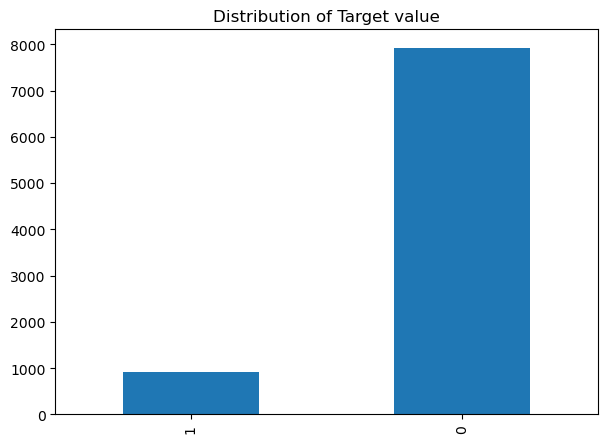

In [44]:
plt.figure(figsize = (7,5))
full_df.Success.value_counts().sort_values().plot(kind = 'bar')
plt.title('Distribution of Target value')
plt.show()

In [45]:
# Define X and y
X = full_df.drop(columns=['Success'])
y = full_df['Success']

# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle = True,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)
# Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Scale the data
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## 3-0. Define Baseline Model

### Generate class for efficiency

In [46]:
class ModelEvaluator:
    def __init__(self):
        self.graph_df = pd.DataFrame(columns = ['Method', 'f1_score', 'pr_auc_score'])

    def calculate_update_score(self, model, method, selected_features, manual_X_train=None, manual_X_test=None):

        # if selected_features == 'manual' and manual_X_train is not None and manual_X_test is not None:
        if isinstance(selected_features, str) and selected_features == 'manual' and manual_X_train is not None and manual_X_test is not None:
            sel_X_train = manual_X_train
            sel_X_train = manual_X_train
            sel_X_test = manual_X_test
            num_features = manual_X_train.shape[1]
        else:
            sel_X_train = X_train_scaled[selected_features]
            sel_X_test = X_test_scaled[selected_features]
            num_features = len(selected_features)

        model.fit(sel_X_train, y_train)

        y_pred = model.predict(sel_X_test)
        y_probs = model.predict_proba(sel_X_test)[:, 1]

        f1 = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
        pr_auc = round(average_precision_score(y_test, y_probs), 3)

        print(f'{method}_n_features_{num_features}_f1_score :, {f1}')
        print(f'{method}_n_features_{num_features}_pr_auc_score : {pr_auc}')

        # Append results to the graph DataFrame
        new_row = pd.DataFrame([{
            'Method' : f'{method}_n_features_{num_features}',
            # 'Method' : f'{method}',
            'f1_score' : f1,
            'pr_auc_score' : pr_auc
        }],)
        self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)

    def plot_scores(self):
        graph_df_long = self.graph_df.melt(id_vars = 'Method', var_name = 'Metric', value_name = 'Score')

        # Dynamically adjust the figure width based on the number of methods
        fig_width = max(8, len(self.graph_df['Method'].unique()) * 2)  # Ensures a minimum width of 8
        plt.figure(figsize=(fig_width, 6))

        # Plot with seaborn
        ax = sns.barplot(x = 'Method', y = 'Score', hue = 'Metric', data = graph_df_long)
        plt.title('Comparison of F1 score and PR-AUC score by method')
        plt.ylabel('Score')
        plt.xlabel('Method')
        plt.ylim(0,1)
        ax.legend(loc = 'upper left', bbox_to_anchor=(1, 1))

        # Add values on top of each bar
        for container in ax.containers:
            ax.bar_label(container, fmt = '%.3f', padding = 3)

        plt.xticks(rotation = 45, ha = 'right')
        plt.tight_layout()
        plt.show()

In [47]:
evaluator = ModelEvaluator()

In [48]:
dt_clf = tree.DecisionTreeClassifier(random_state= 42)
evaluator.calculate_update_score(dt_clf, method = 'DecisionTree', selected_features = X.columns)
# evaluator.plot_scores()

DecisionTree_n_features_29_f1_score :, 0.853
DecisionTree_n_features_29_pr_auc_score : 0.181


In [49]:
knn_clf = KNeighborsClassifier()
evaluator.calculate_update_score(knn_clf, method = 'KNN', selected_features = X.columns)
# evaluator.plot_scores()

KNN_n_features_29_f1_score :, 0.859
KNN_n_features_29_pr_auc_score : 0.188


In [50]:
lr_clf = LogisticRegression(solver = 'liblinear',random_state=42)
evaluator.calculate_update_score(lr_clf, method = 'Logistic_Regression', selected_features = X.columns)
# evaluator.plot_scores()

Logistic_Regression_n_features_29_f1_score :, 0.859
Logistic_Regression_n_features_29_pr_auc_score : 0.332


In [51]:
rf_clf = RandomForestClassifier(random_state=42)
evaluator.calculate_update_score(rf_clf, method = 'RF', selected_features = X.columns)
# evaluator.plot_scores()

RF_n_features_29_f1_score :, 0.868
RF_n_features_29_pr_auc_score : 0.439


In [52]:
gbm_clf = GradientBoostingClassifier(random_state=42)
evaluator.calculate_update_score(gbm_clf, method = 'GBM', selected_features = X.columns)
# evaluator.plot_scores()

GBM_n_features_29_f1_score :, 0.879
GBM_n_features_29_pr_auc_score : 0.472


In [53]:
xgb_clf = XGBClassifier(random_state=42)
evaluator.calculate_update_score(xgb_clf, method = 'XGB', selected_features = X.columns)
# evaluator.plot_scores()

XGB_n_features_29_f1_score :, 0.89
XGB_n_features_29_pr_auc_score : 0.474


In [54]:
cb_clf = CatBoostClassifier(verbose = 0, random_state = 42)
evaluator.calculate_update_score(cb_clf, method = 'CatBoost', selected_features = X.columns)
# evaluator.plot_scores()

CatBoost_n_features_29_f1_score :, 0.885
CatBoost_n_features_29_pr_auc_score : 0.459


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
LGBM_n_features_29_f1_score :, 0.884
LGBM_n_features_29_pr_auc_score : 0.453


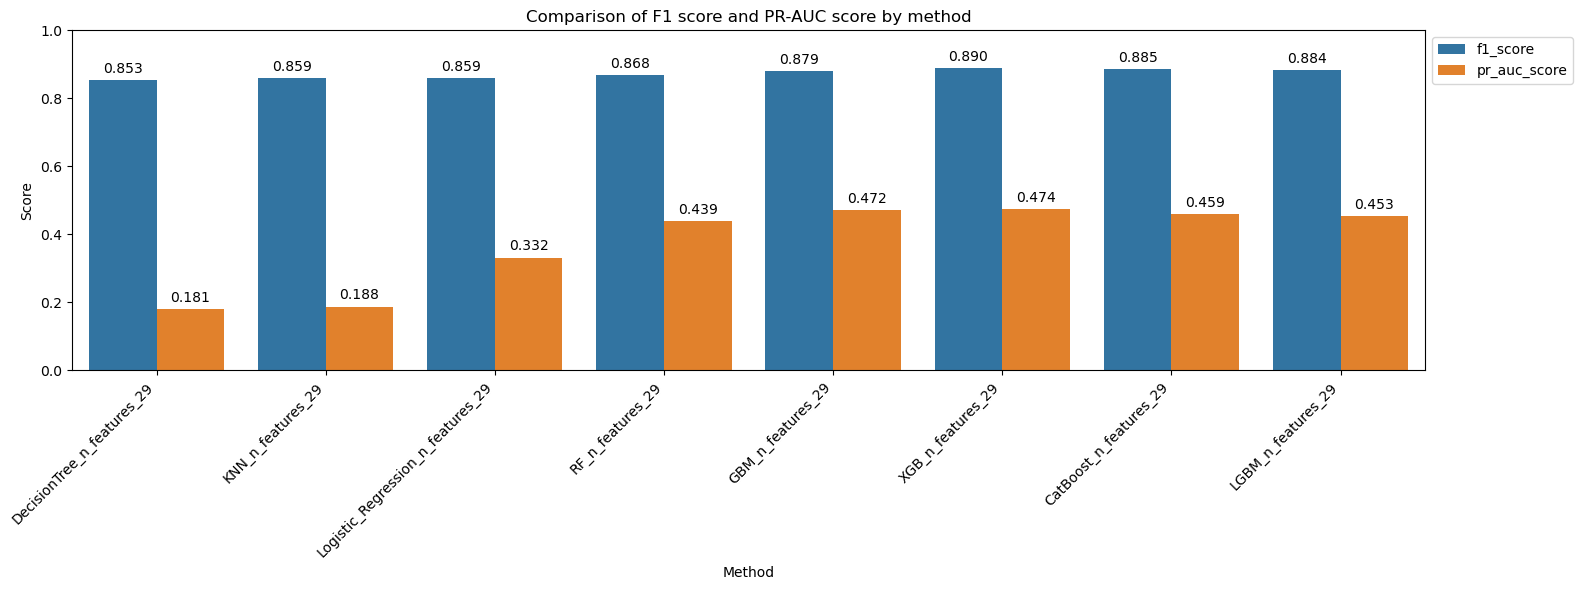

In [55]:
lgbm_clf = LGBMClassifier(random_state=42, verbose = 0)
evaluator.calculate_update_score(lgbm_clf, method = 'LGBM', selected_features = X.columns)
evaluator.plot_scores()

    I selected XGBoost as the baseline model due to its relatively high F1 and PR-AUC scores.

In [56]:
base_model = xgb_clf

## 3-1. Filter Methods -(1) Variance Threshold

In [57]:
scaler = MinMaxScaler()

X_train_scaled_minmax = scaler.fit_transform(X_train)

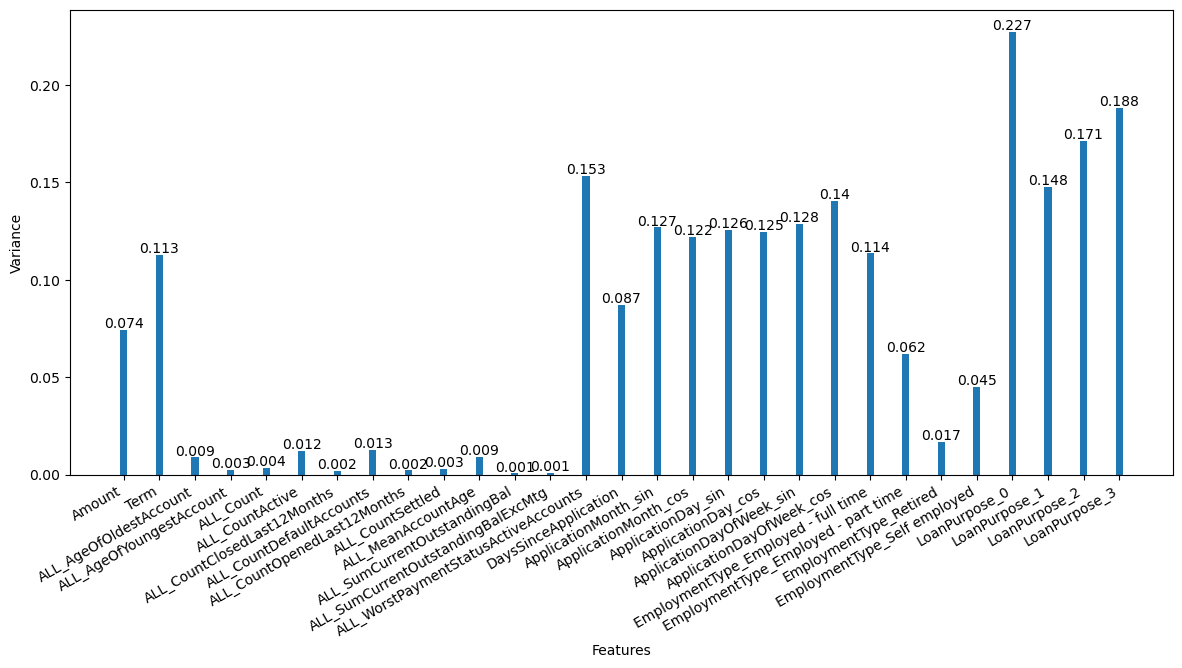

In [58]:
fig, ax = plt.subplots(figsize = (12,6))

x = X.columns
y = X_train_scaled_minmax.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
# ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

In [93]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.89
base_xgb_n_features_29_pr_auc_score : 0.474


In [98]:
var_threshold = 0.15
# var_threshold = 0.05
var_selected_cols = X.columns[[value > var_threshold for value in X_train_scaled_minmax.var(axis=0)]]
print(var_selected_cols)

Index(['ALL_WorstPaymentStatusActiveAccounts', 'LoanPurpose_0',
       'LoanPurpose_2', 'LoanPurpose_3'],
      dtype='object')


Var_threshole_0.15_n_features_4_f1_score :, 0.847
Var_threshole_0.15_n_features_4_pr_auc_score : 0.159


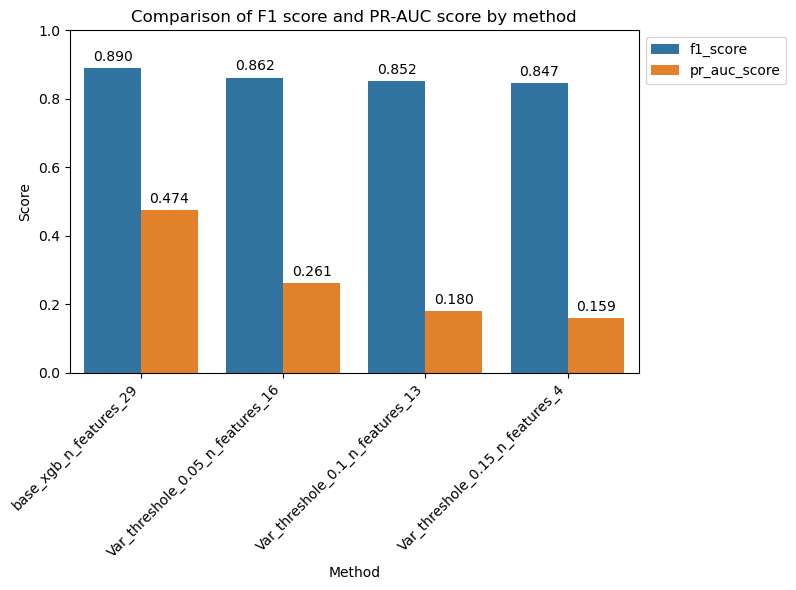

In [99]:
evaluator.calculate_update_score(base_model, method = f'Var_threshole_{var_threshold}', selected_features=var_selected_cols)
evaluator.plot_scores()

    After dropping some low-variance columns, the F1 and PR-AUC scores decreased, so I decided not to drop any columns moving forward.

## 3-1. Filter Methods - (2) Correlation

When the correlation between features exceeds 0.8, keep the one with a higher correlation to the target and drop the other. Then, keep only the top N features with the highest correlation to the target.

In [62]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)
# evaluator.plot_scores()

base_xgb_n_features_29_f1_score :, 0.89
base_xgb_n_features_29_pr_auc_score : 0.474


In [ ]:
# Calculate the correlation matrix using Spearman
correlation_matrix = full_df.corr(method='spearman')

# Calculate correlation of each feature with the target
target_corr = full_df.corr()['Success'].abs().drop('Success')

# Identify pairs of features with high inter-correlation
correlation_threshold = 0.8
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# For each pair of highly correlated features, drop the one with the lower correlation to the target
to_drop = set()
for column in upper_triangle.columns:
    high_corr_features = upper_triangle.index[upper_triangle[column].abs() > correlation_threshold].tolist()
    for feature in high_corr_features:
        # Compare correlation with the target and keep the more correlated feature
        if target_corr[feature] > target_corr[column]:
            to_drop.add(column)
        else:
            to_drop.add(feature)

# Drop the selected features from X_train
print(to_drop)
X_reduced = X.drop(columns=to_drop)

{'ALL_CountSettled', 'ALL_Count', 'ALL_CountDefaultAccounts'}


In [64]:
# Select top features with the highest absolute correlation to the target
n = 15  # Number of top features to keep
corr_selected_cols = target_corr.drop(index=to_drop).nlargest(n).index.tolist()

print("Selected features:", corr_selected_cols)

Selected features: ['ALL_WorstPaymentStatusActiveAccounts', 'Amount', 'ALL_MeanAccountAge', 'ALL_AgeOfOldestAccount', 'ALL_CountOpenedLast12Months', 'ALL_CountActive', 'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_SumCurrentOutstandingBal', 'DaysSinceApplication', 'ALL_CountClosedLast12Months', 'ApplicationMonth_sin', 'EmploymentType_Employed - part time', 'EmploymentType_Self employed', 'LoanPurpose_2', 'ApplicationDay_sin']


In [65]:
corr_selected_cols

['ALL_WorstPaymentStatusActiveAccounts',
 'Amount',
 'ALL_MeanAccountAge',
 'ALL_AgeOfOldestAccount',
 'ALL_CountOpenedLast12Months',
 'ALL_CountActive',
 'ALL_SumCurrentOutstandingBalExcMtg',
 'ALL_SumCurrentOutstandingBal',
 'DaysSinceApplication',
 'ALL_CountClosedLast12Months',
 'ApplicationMonth_sin',
 'EmploymentType_Employed - part time',
 'EmploymentType_Self employed',
 'LoanPurpose_2',
 'ApplicationDay_sin']

- Corr_1 : For each pair of highly correlated features, drop the one with the lower correlation to the target only -> n_features = 25
- Corr_ : Corr_1 + chosse top N features in the order of highest absolute correlation to the target -> n_features = 10

Corr_1_n_features_26_f1_score :, 0.89
Corr_1_n_features_26_pr_auc_score : 0.433


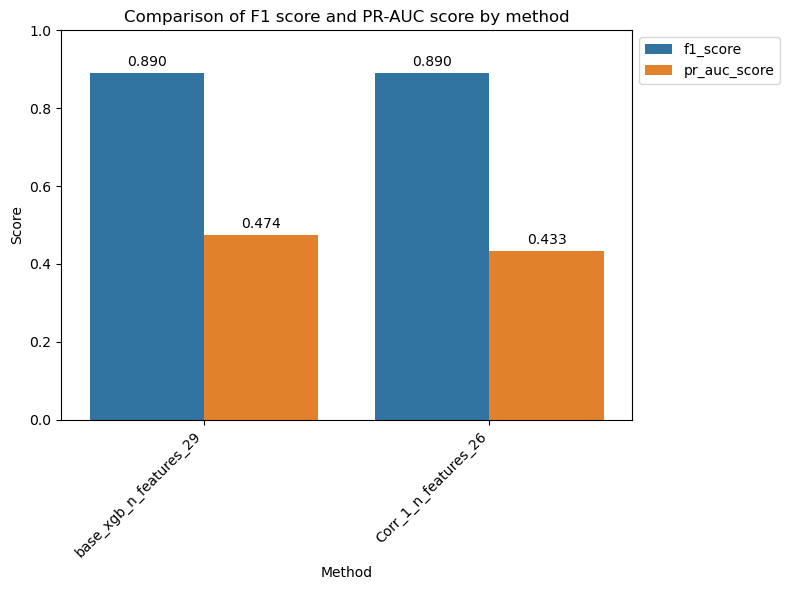

In [66]:
evaluator.calculate_update_score(base_model, method = 'Corr_1', selected_features = X_reduced.columns)
# evaluator.calculate_update_score(base_model, method = 'Corr', selected_features = corr_selected_cols)

evaluator.plot_scores()

In [67]:
def number_of_top_features(n):
    corr_selected_cols = target_corr.drop(index=to_drop).nlargest(n).index.tolist()
    evaluator.calculate_update_score(base_model, method = 'Corr', selected_features = corr_selected_cols)
    # evaluator.plot_scores()

for i in range(3,20,2):
    number_of_top_features(i)

Corr_n_features_3_f1_score :, 0.858
Corr_n_features_3_pr_auc_score : 0.288
Corr_n_features_5_f1_score :, 0.86
Corr_n_features_5_pr_auc_score : 0.309
Corr_n_features_7_f1_score :, 0.873
Corr_n_features_7_pr_auc_score : 0.366
Corr_n_features_9_f1_score :, 0.882
Corr_n_features_9_pr_auc_score : 0.439
Corr_n_features_11_f1_score :, 0.885
Corr_n_features_11_pr_auc_score : 0.418
Corr_n_features_13_f1_score :, 0.886
Corr_n_features_13_pr_auc_score : 0.436
Corr_n_features_15_f1_score :, 0.882
Corr_n_features_15_pr_auc_score : 0.413
Corr_n_features_17_f1_score :, 0.878
Corr_n_features_17_pr_auc_score : 0.425
Corr_n_features_19_f1_score :, 0.888
Corr_n_features_19_pr_auc_score : 0.434


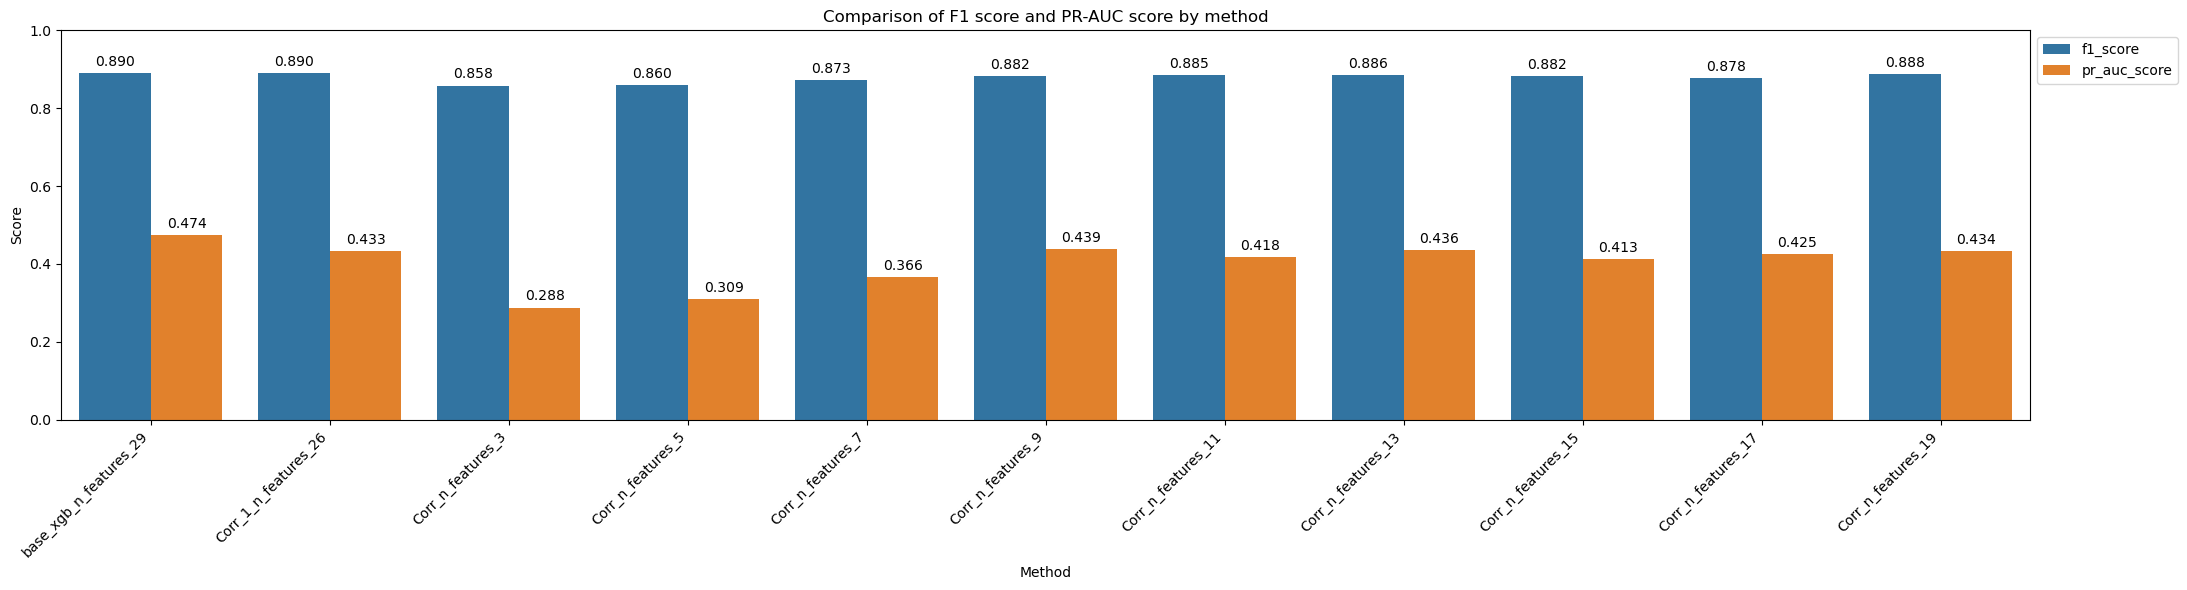

In [68]:
evaluator.plot_scores()

    We found that reducing the number of features to a very small set, like 5, leads to a low PR-AUC score. However, aside from this extreme case, the scores remain stable regardless of the number of features.

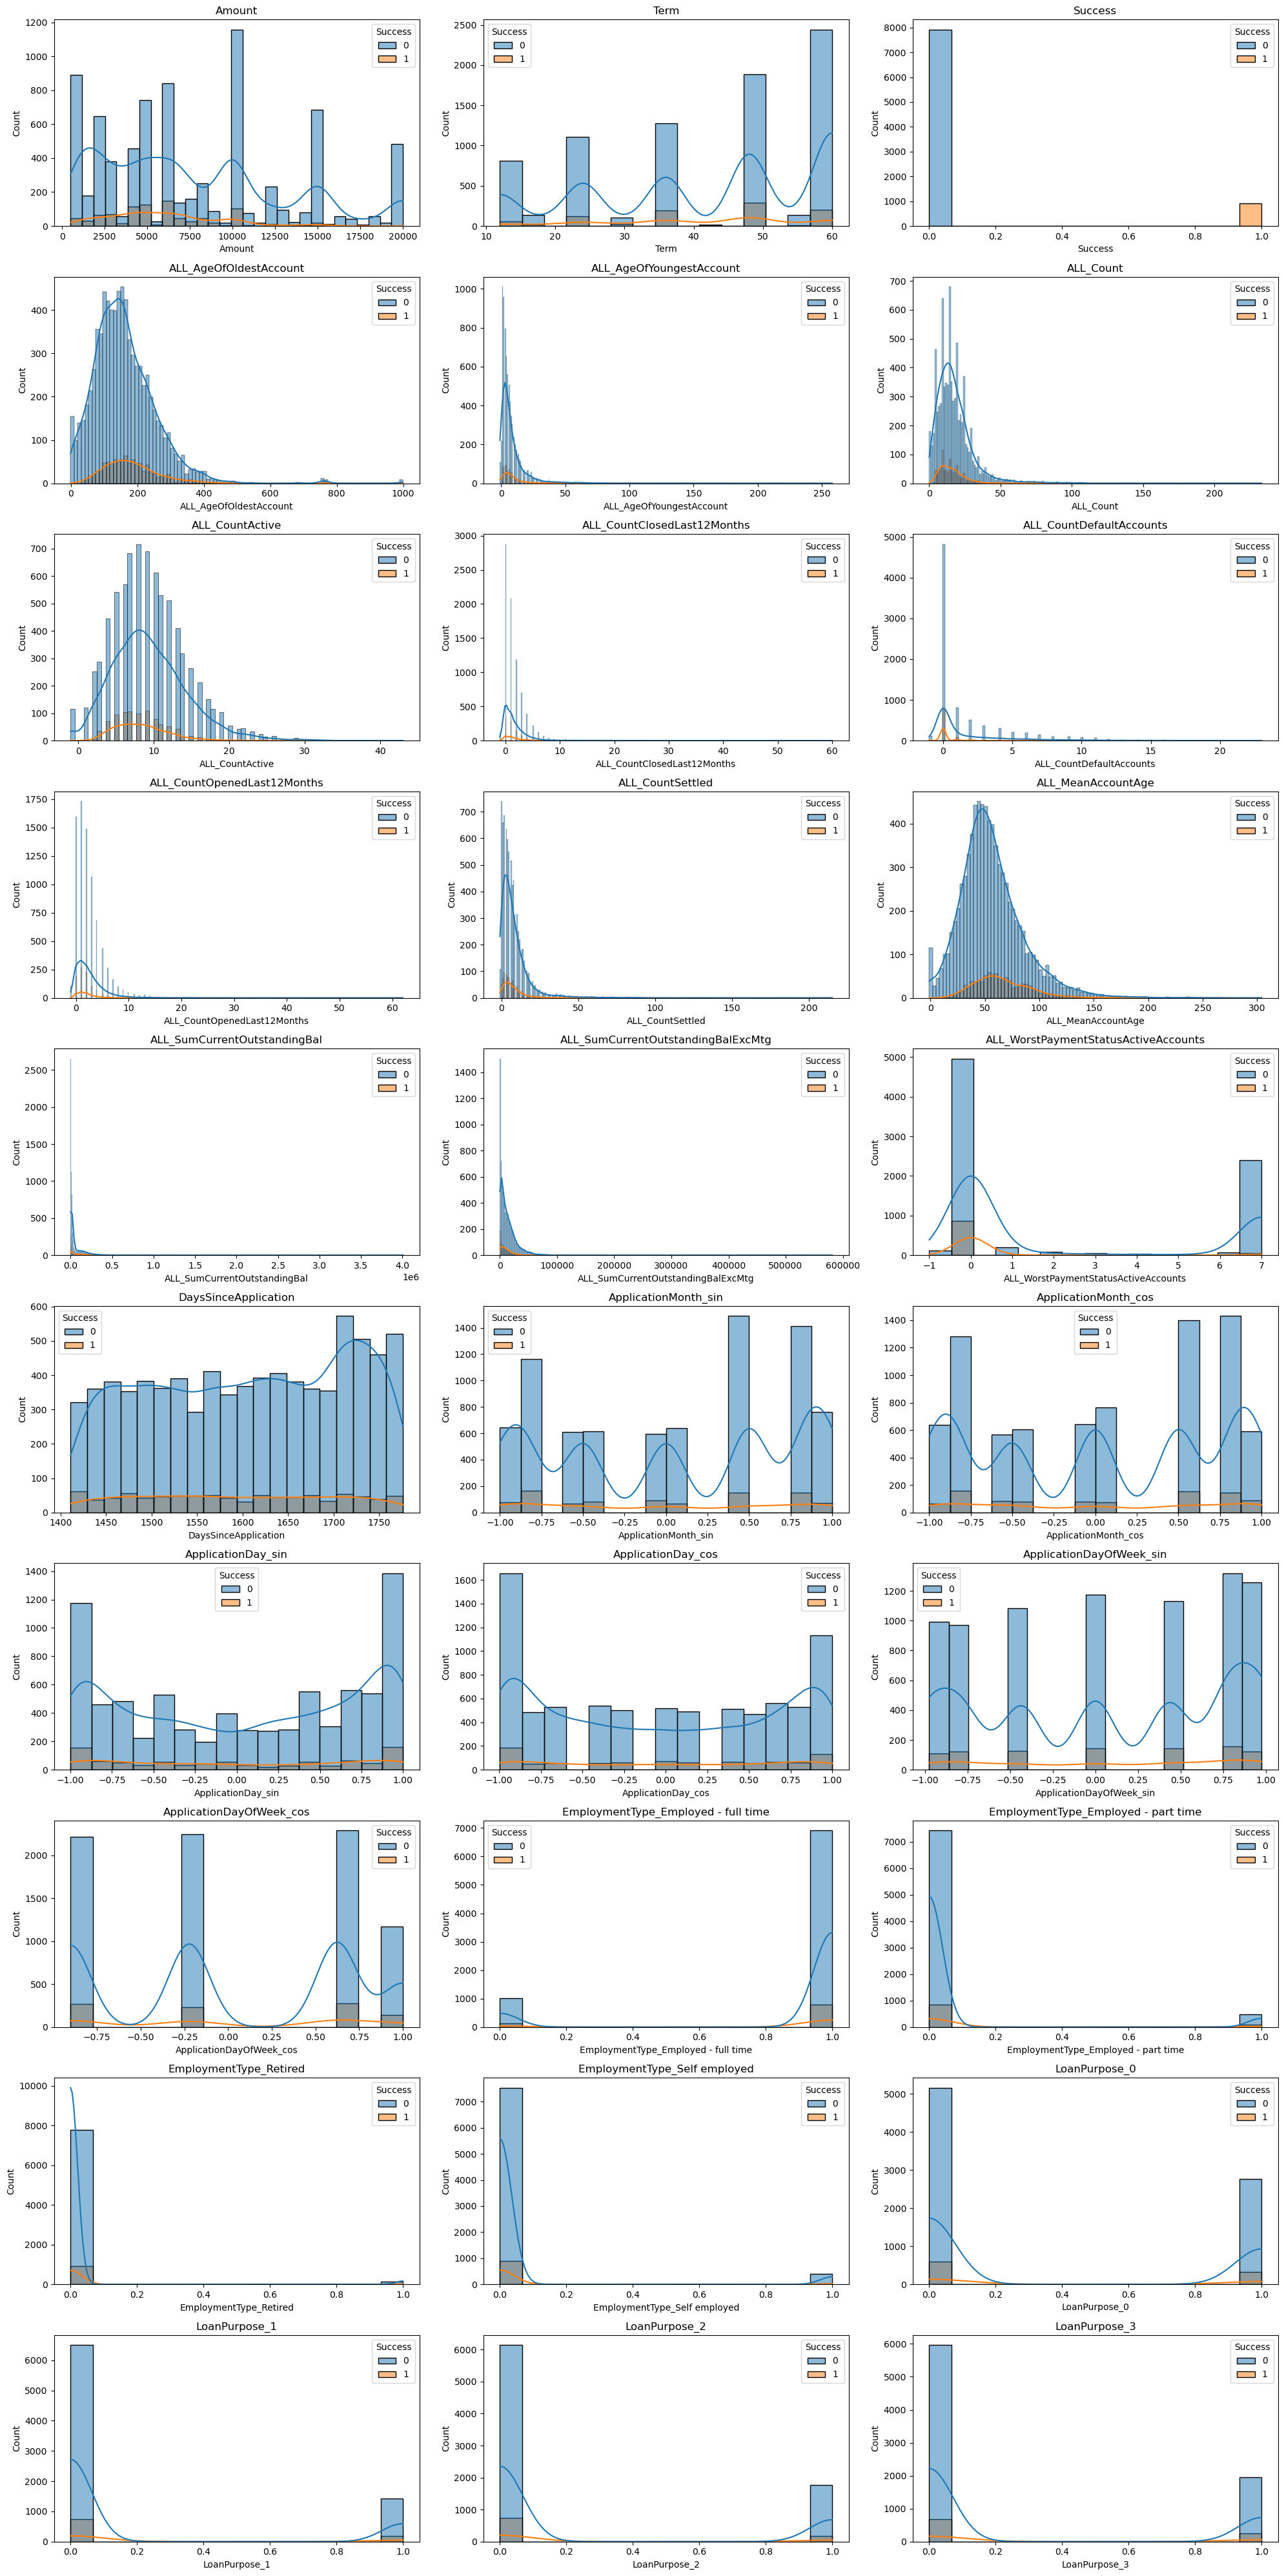

In [69]:
num_features = full_df.select_dtypes(include=['float64', 'int64']).columns

num_plots = len(num_features)
ncols = 3
nrows = (num_plots // ncols) + (num_plots % ncols > 0)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, nrows * 4))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.histplot(data = full_df, x = feature, hue = 'Success', kde = True, ax = axes[i])
    axes[i].set_title(feature)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 3-1. Filter Method - (3) Mutual Information

In [70]:
f1_score_list = []
pr_auc_score_list = []

In [71]:
len(X.columns)

29

In [72]:
for k in range(1, len(X.columns)+1):
    selector = SelectKBest(mutual_info_classif, k = k)
    selector.fit(X_train, y_train)

    kbest_X_train = selector.transform(X_train)
    kbest_X_test = selector.transform(X_test)

    base_model.fit(kbest_X_train, y_train)
    kbest_y_pred = base_model.predict(kbest_X_test)
    kbest_y_probs = base_model.predict_proba(kbest_X_test)[:, 1]

    kbest_f1_score = round(f1_score(y_test, kbest_y_pred, average = 'weighted'), 3)
    kbest_pr_auc_score = round(average_precision_score(y_test, kbest_y_probs), 3)

    f1_score_list.append(kbest_f1_score)
    pr_auc_score_list.append(kbest_pr_auc_score)


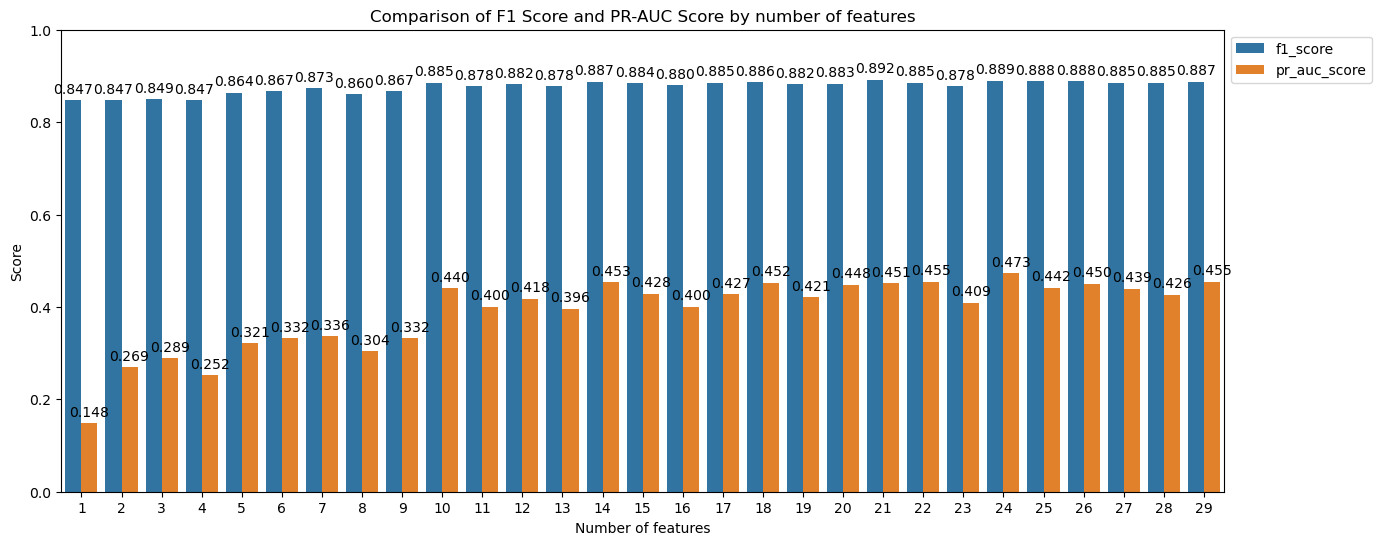

In [73]:
temp_df = pd.DataFrame({
    'number_features' : range(1,len(X.columns)+1),
    'f1_score' : f1_score_list,
    'pr_auc_score' : pr_auc_score_list
})

# Melt the DataFrame into long format
temp_df_long = temp_df.melt(id_vars='number_features', var_name='Metric', value_name='Score')

# Plot with Seaborn
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='number_features', y='Score', hue='Metric', data= temp_df_long)
plt.title('Comparison of F1 Score and PR-AUC Score by number of features')
plt.ylabel('Score')
plt.xlabel('Number of features')
plt.ylim(0,1)
ax.legend(loc = 'upper left', bbox_to_anchor=(1, 1))

# Add values on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.show()

In [100]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.89
base_xgb_n_features_29_pr_auc_score : 0.474


In [92]:
selector = SelectKBest(mutual_info_classif, k = 15)
selector.fit(X_train, y_train)

selected_feature_mask = selector.get_support()

mi_sel_features = X_train.columns[selected_feature_mask]

mi_sel_features

Index(['Amount', 'Term', 'ALL_AgeOfOldestAccount', 'ALL_AgeOfYoungestAccount',
       'ALL_CountActive', 'ALL_CountDefaultAccounts',
       'ALL_CountOpenedLast12Months', 'ALL_MeanAccountAge',
       'ALL_SumCurrentOutstandingBalExcMtg',
       'ALL_WorstPaymentStatusActiveAccounts', 'ApplicationMonth_cos',
       'ApplicationDayOfWeek_cos', 'EmploymentType_Self employed',
       'LoanPurpose_0', 'LoanPurpose_1'],
      dtype='object')

Filter_MI_n_features_5_f1_score :, 0.855
Filter_MI_n_features_5_pr_auc_score : 0.291


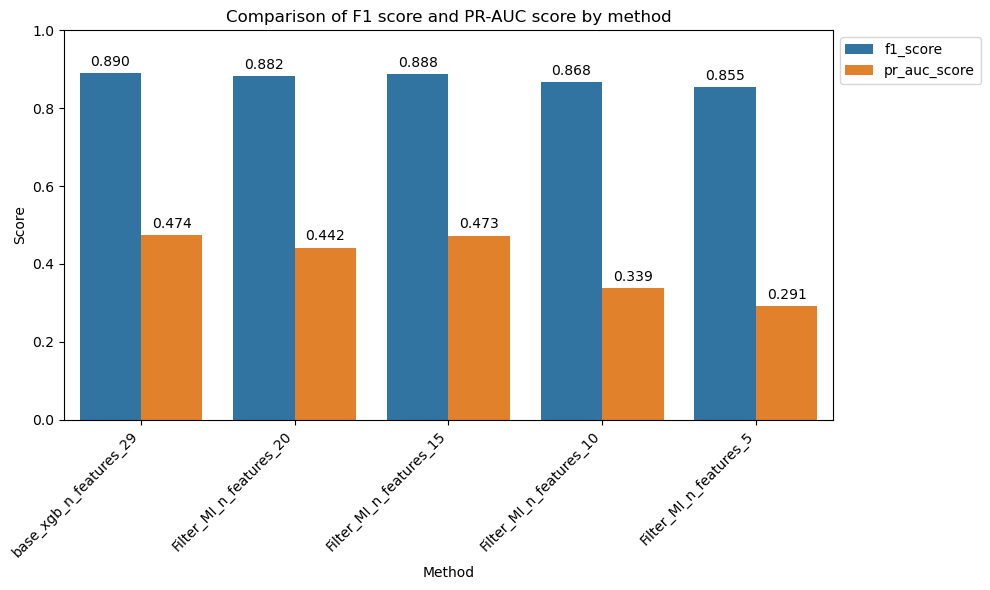

In [91]:
evaluator.calculate_update_score(base_model, method = 'Filter_MI', selected_features = mi_sel_features)
evaluator.plot_scores()

    Similarly, when the feature count drops below certain number, the PR-AUC score begins to decrease. Therefore, it’s preferable to keep around 15 features for optimal performance.

## 3-2. Wrapper Methods - Recursive feature Elimination (RFE)

In [102]:
# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom scorers for weighted F1 and PR-AUC
weighted_f1_scorer = make_scorer(f1_score, average='weighted')
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Use RFECV to perform RFE with cross-validation
# We specify 'f1' as the scoring to optimize F1-score during feature selection
selector = RFECV(estimator=base_model, step=1, cv=cv_strategy, scoring = weighted_f1_scorer, min_features_to_select=5)
selector.fit(X_train_scaled, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...),
      min_features_to_select=5,
      scoring=make_scorer(f1_score, average=weighted))

In [103]:
# Print selected feature names
selected_features = X_train.columns[selector.support_]
optimal_n_features = selector.n_features_
optimal_score = max(selector.cv_results_['mean_test_score'])
print("Optimal number of features : ", optimal_n_features)
print("Selected Features:", selected_features.to_list())
print("Cross-validated Weighted F1 Score at optimal features", round(optimal_score,2))

Optimal number of features :  10
Selected Features: ['Amount', 'ALL_Count', 'ALL_CountActive', 'ALL_CountDefaultAccounts', 'ALL_MeanAccountAge', 'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_WorstPaymentStatusActiveAccounts', 'EmploymentType_Employed - full time', 'LoanPurpose_3']
Cross-validated Weighted F1 Score at optimal features 0.88


In [104]:
##############################################################
# Transform X to keep only the selected features
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Re-fit the model on the training set with selected features
base_model.fit(X_train_selected, y_train)

# Predict probabilities on the test set to adjust the threshold
y_probs = base_model.predict_proba(X_test_selected)[:, 1]
y_pred = base_model.predict(X_test_selected)

# Try different thresholds to optimize F1 score
f1 = f1_score(y_test, y_pred, average= 'weighted')
pr_auc = average_precision_score(y_test, y_probs)
rfe_pr_auc = pr_auc

print("Weighted F1 score with selected features:", round(f1,3))
print("PR-AUC with selected features:", round(pr_auc,3))

Weighted F1 score with selected features: 0.888
PR-AUC with selected features: 0.426


In [105]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.89
base_xgb_n_features_29_pr_auc_score : 0.474


Wrapper_RFE_n_features_10_f1_score :, 0.888
Wrapper_RFE_n_features_10_pr_auc_score : 0.426


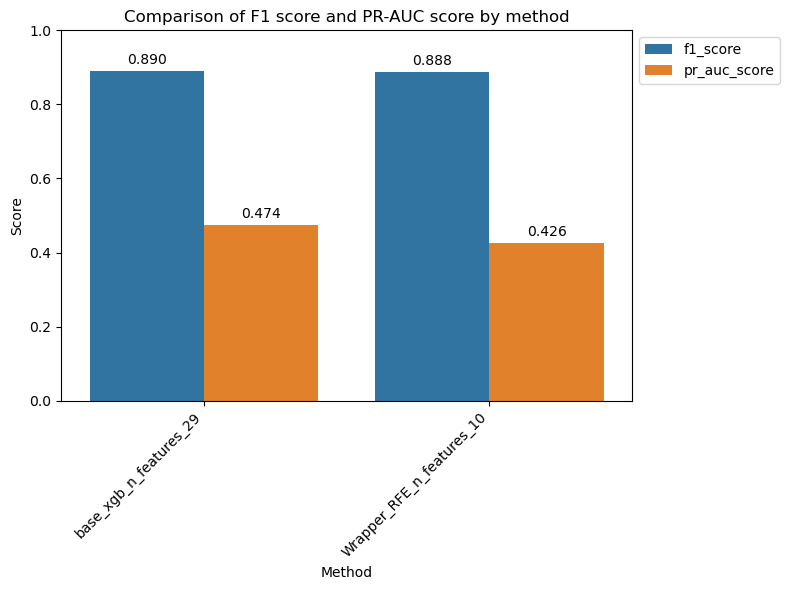

In [106]:
evaluator.calculate_update_score(base_model, method = 'Wrapper_RFE', selected_features = selected_features)
evaluator.plot_scores()

    - It gives us 10 selected features and still has okay scores

## 3-3. Embedded Methods

### Lasso

In [107]:
param_dist = {'C': loguniform(0.001, 1)}
feature_names = X.columns

model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=weighted_f1_scorer, cv=cv, n_iter=10, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Get the best C value and F1 score
best_C = random_search.best_params_['C']
best_score = random_search.best_score_
print(f"Best C from Random Search: {best_C}")
print(f"Best Weighted F1 Score from Random Search: {best_score:.3f}")

# Check the number of selected features
best_model = random_search.best_estimator_
num_selected_features = np.sum(best_model.coef_[0] != 0)
print(f"Number of selected features with best C: {num_selected_features}")
lasso_coefficients = best_model.coef_[0]
selected_features_lasso = [feature_names[i] for i, coef in enumerate(lasso_coefficients) if coef != 0]
print("Selected features by Lasso:", selected_features_lasso)

Best C from Random Search: 0.7114476009343418
Best Weighted F1 Score from Random Search: 0.855
Number of selected features with best C: 24
Selected features by Lasso: ['Amount', 'Term', 'ALL_AgeOfOldestAccount', 'ALL_AgeOfYoungestAccount', 'ALL_CountActive', 'ALL_CountDefaultAccounts', 'ALL_CountOpenedLast12Months', 'ALL_CountSettled', 'ALL_MeanAccountAge', 'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_WorstPaymentStatusActiveAccounts', 'DaysSinceApplication', 'ApplicationMonth_sin', 'ApplicationMonth_cos', 'ApplicationDay_sin', 'ApplicationDay_cos', 'ApplicationDayOfWeek_sin', 'EmploymentType_Employed - full time', 'EmploymentType_Retired', 'EmploymentType_Self employed', 'LoanPurpose_0', 'LoanPurpose_1', 'LoanPurpose_3']


    This method resulted in 24 features, with an F1 score slightly lower than our previous model.

### Feature Importances

In [108]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.89
base_xgb_n_features_29_pr_auc_score : 0.474


In [109]:
# Set up the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

feature_importances = []

# For each fold, train the model and extract feature importance
for train_idx, val_idx in cv.split(X_train_scaled, y_train):

    # Split training and validation data
    X_fold_train, X_fold_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model
    base_model.fit(X_fold_train, y_fold_train)

    # Store feature importances from this fold
    feature_importances.append(base_model.feature_importances_)

# Calculate the mean feature importance across all folds
mean_importances = np.mean(feature_importances, axis=0)

# Organize feature importances into a DataFrame for better readability
feature_names = X.columns.to_list()
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': mean_importances})

# Custom scorer
weighted_f1_scorer = make_scorer(f1_score, average='weighted')
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

In [110]:
#  Select the top N features
top_n = 30
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
top_n_features = selected_features_top_n['Feature'].values
print("Top N Features:\n", selected_features_top_n)

Top N Features:
                                  Feature  Importance
13  ALL_WorstPaymentStatusActiveAccounts    0.222372
0                                 Amount    0.063029
7               ALL_CountDefaultAccounts    0.047930
12    ALL_SumCurrentOutstandingBalExcMtg    0.039831
10                    ALL_MeanAccountAge    0.038403
5                        ALL_CountActive    0.035554
11          ALL_SumCurrentOutstandingBal    0.034197
8            ALL_CountOpenedLast12Months    0.033558
21   EmploymentType_Employed - full time    0.030312
4                              ALL_Count    0.029399
22   EmploymentType_Employed - part time    0.028011
15                  ApplicationMonth_sin    0.024961
28                         LoanPurpose_3    0.024926
26                         LoanPurpose_1    0.024172
2                 ALL_AgeOfOldestAccount    0.023764
3               ALL_AgeOfYoungestAccount    0.023671
17                    ApplicationDay_sin    0.023197
18                    Applica

FeatureImportance_n_features_3_f1_score :, 0.847
FeatureImportance_n_features_3_pr_auc_score : 0.269
FeatureImportance_n_features_4_f1_score :, 0.858
FeatureImportance_n_features_4_pr_auc_score : 0.276
FeatureImportance_n_features_5_f1_score :, 0.872
FeatureImportance_n_features_5_pr_auc_score : 0.345
FeatureImportance_n_features_6_f1_score :, 0.879
FeatureImportance_n_features_6_pr_auc_score : 0.381
FeatureImportance_n_features_7_f1_score :, 0.884
FeatureImportance_n_features_7_pr_auc_score : 0.402
FeatureImportance_n_features_8_f1_score :, 0.88
FeatureImportance_n_features_8_pr_auc_score : 0.422
FeatureImportance_n_features_9_f1_score :, 0.882
FeatureImportance_n_features_9_pr_auc_score : 0.419
FeatureImportance_n_features_10_f1_score :, 0.882
FeatureImportance_n_features_10_pr_auc_score : 0.432
FeatureImportance_n_features_11_f1_score :, 0.885
FeatureImportance_n_features_11_pr_auc_score : 0.423
FeatureImportance_n_features_12_f1_score :, 0.883
FeatureImportance_n_features_12_pr_auc

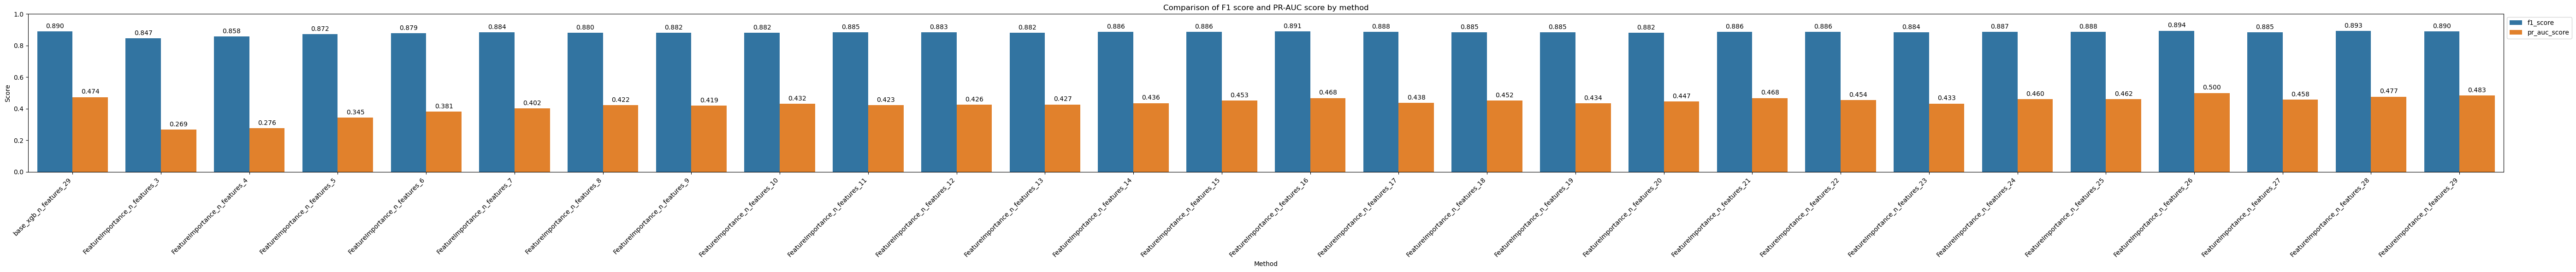

In [111]:
def number_of_top_features_fi(n):
    selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(n)
    evaluator.calculate_update_score(base_model, method = 'FeatureImportance', selected_features = selected_features_top_n['Feature'].values)
    # evaluator.plot_scores()

for i in range(3,30):
    number_of_top_features_fi(i)

evaluator.plot_scores()

In [112]:
top_n = 10
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
fi_top_n_features = selected_features_top_n['Feature'].values
print(fi_top_n_features)
# It means those features are really important

['ALL_WorstPaymentStatusActiveAccounts' 'Amount'
 'ALL_CountDefaultAccounts' 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive' 'ALL_SumCurrentOutstandingBal'
 'ALL_CountOpenedLast12Months' 'EmploymentType_Employed - full time'
 'ALL_Count']


In [113]:
top_n = 15
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
fi_top_n_features = selected_features_top_n['Feature'].values
print(fi_top_n_features)

['ALL_WorstPaymentStatusActiveAccounts' 'Amount'
 'ALL_CountDefaultAccounts' 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive' 'ALL_SumCurrentOutstandingBal'
 'ALL_CountOpenedLast12Months' 'EmploymentType_Employed - full time'
 'ALL_Count' 'EmploymentType_Employed - part time' 'ApplicationMonth_sin'
 'LoanPurpose_3' 'LoanPurpose_1' 'ALL_AgeOfOldestAccount']


In [114]:
top_n = 20
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
fi_top_n_features = selected_features_top_n['Feature'].values
print(fi_top_n_features)

['ALL_WorstPaymentStatusActiveAccounts' 'Amount'
 'ALL_CountDefaultAccounts' 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive' 'ALL_SumCurrentOutstandingBal'
 'ALL_CountOpenedLast12Months' 'EmploymentType_Employed - full time'
 'ALL_Count' 'EmploymentType_Employed - part time' 'ApplicationMonth_sin'
 'LoanPurpose_3' 'LoanPurpose_1' 'ALL_AgeOfOldestAccount'
 'ALL_AgeOfYoungestAccount' 'ApplicationDay_sin' 'ApplicationDay_cos'
 'DaysSinceApplication' 'LoanPurpose_2']


    we still get good scores even though the number of feature drops to around 10. (finally getting some of one-hot encoded features in TOP 10 list)

## 3-4. PCA (Dimentionality Reduction)

In [115]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.89
base_xgb_n_features_29_pr_auc_score : 0.474


In [120]:
pca = PCA(n_components=5)
pca_X_train = pca.fit_transform(X_train_scaled)
pca_X_test = pca.transform(X_test_scaled)

PCA_n_features_5_f1_score :, 0.849
PCA_n_features_5_pr_auc_score : 0.199


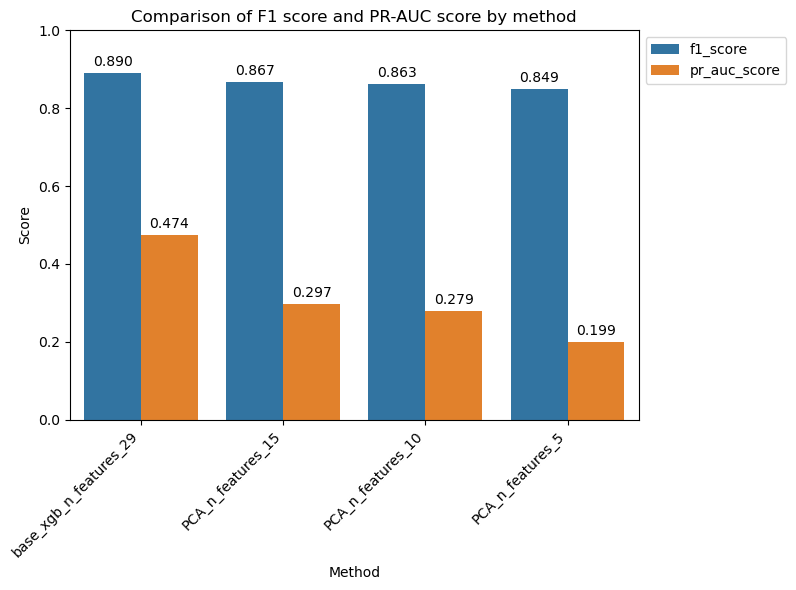

In [121]:
evaluator.calculate_update_score(base_model, method = 'PCA', selected_features = 'manual', manual_X_train= pca_X_train, manual_X_test=pca_X_test)
evaluator.plot_scores()

    For PCA, as we reduced the dimensionality, both the F1 and PR-AUC scores progressively decreased. Therefore, we decided not to consider this approach for this time.

# 4. Modeling & Evaluation

We have three main objectives:

	1.	Improve performance by tuning hyperparameters while keeping all features intact.
	2.	Reduce the number of features to lower model complexity, aiming to achieve similar or better performance.
	3.	Reduce the number of features and tune hyperparameters to achieve similar or better performance.

And we will check them step by step  

	1.	base model itself.  
	2.	base model + selected features.  
	3.	hyper param tuned model + selected features.  


In [170]:
def evaluate_model(model, x_test, y_test, desired_precision):
    # Predict test data
    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    acc = round(accuracy_score(y_test, y_pred),3)
    prec = round(precision_score(y_test, y_pred),3)
    rec = round(recall_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
    pr_auc = round(average_precision_score(y_test, y_probs), 3)

    # Display Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    clf_report = clf_report.round(3)

    # Precision-Recall curve and threshold adjustment
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    selected_threshold = None
    for p, r, t in zip(precision, recall, thresholds):
        if p >= desired_precision:
            selected_threshold = t
            y_pred_adjusted = (y_probs >= selected_threshold).astype(int)

            # Calculate precision and recall at the adjusted threshold
            precision_adj = precision_score(y_test, y_pred_adjusted)
            recall_adj = recall_score(y_test, y_pred_adjusted)

            print(f"Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}")
            print(f"Adjusted Precision: {precision_adj:.2f}, Adjusted Recall: {recall_adj:.2f}")
            break

    # Plot the Precision-Recall curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='.', label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{type(model).__name__}_feature_{x_test.shape[1]}_Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Print final metrics
    print('F1 Score:', f1)
    print('PR-AUC Score:', pr_auc)
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('--------------------------------')
    print('Confusion Matrix:\n', cm)
    print('--------------------------------')
    print('Classification Report:\n', clf_report)

#### Correlation
-> 15 features
> ['ALL_WorstPaymentStatusActiveAccounts','Amount','ALL_MeanAccountAge','ALL_AgeOfOldestAccount',
'ALL_CountOpenedLast12Months','ALL_CountActive','ALL_SumCurrentOutstandingBalExcMtg',
'ALL_SumCurrentOutstandingBal','DaysSinceApplication','ALL_CountClosedLast12Months','ApplicationMonth_sin',
'EmploymentType_Employed - part time','EmploymentType_Self employed','LoanPurpose_2','ApplicationDay_sin']
 #### MI
 -> 15
 > ['Amount', 'Term', 'ALL_AgeOfOldestAccount', 'ALL_AgeOfYoungestAccount','ALL_CountActive',
 'ALL_CountDefaultAccounts','ALL_CountOpenedLast12Months', 'ALL_MeanAccountAge',
'ALL_SumCurrentOutstandingBalExcMtg','ALL_WorstPaymentStatusActiveAccounts', 'ApplicationMonth_cos',
'ApplicationDayOfWeek_cos', 'EmploymentType_Self employed','LoanPurpose_0', 'LoanPurpose_1']

#### RFE
-> 10
> ['Amount', 'ALL_Count', 'ALL_CountActive', 'ALL_CountDefaultAccounts',
'ALL_MeanAccountAge', 'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg',
'ALL_WorstPaymentStatusActiveAccounts', 'EmploymentType_Employed - full time', 'LoanPurpose_3']
#### Feature Importance
-> 15
>['ALL_WorstPaymentStatusActiveAccounts', 'Amount', 'ALL_CountDefaultAccounts', 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive' 'ALL_SumCurrentOutstandingBal'
 'ALL_CountOpenedLast12Months' 'EmploymentType_Employed - full time'
 'ALL_Count' 'EmploymentType_Employed - part time' 'ApplicationMonth_sin'
 'LoanPurpose_3' 'LoanPurpose_1' 'ALL_AgeOfOldestAccount']

**The five variables selected across all methods**  
`['ALL_WorstPaymentStatusActiveAccounts','Amount','ALL_SumCurrentOutstandingBalExcMtg','ALL_MeanAccountAge','ALL_CountActive']`  

**The 13 variables selected by three or more methods**  
`['ALL_WorstPaymentStatusActiveAccounts','Amount','ALL_SumCurrentOutstandingBalExcMtg','ALL_MeanAccountAge','ALL_CountActive',
'ALL_CountDefaultAccounts','ALL_SumCurrentOutstandingBal','ALL_CountOpenedLast12Months','EmploymentType_Employed - part time',
'EmploymentType_Employed - full time','ALL_AgeOfOldestAccount','LoanPurpose_1','LoanPurpose_3']`

In [209]:
final_selected_cols_13 = ['ALL_WorstPaymentStatusActiveAccounts','Amount','ALL_SumCurrentOutstandingBalExcMtg','ALL_MeanAccountAge','ALL_CountActive',
                         'ALL_CountDefaultAccounts','ALL_SumCurrentOutstandingBal','ALL_CountOpenedLast12Months','EmploymentType_Employed - part time',
                         'EmploymentType_Employed - full time','ALL_AgeOfOldestAccount','LoanPurpose_1','LoanPurpose_3']

In [147]:
final_selected_cols_5 = ['ALL_WorstPaymentStatusActiveAccounts','Amount','ALL_SumCurrentOutstandingBalExcMtg','ALL_MeanAccountAge','ALL_CountActive']

### Random Forest

basic model with all features

Threshold: 0.58, Precision: 0.82, Recall: 0.05
Adjusted Precision: 0.82, Adjusted Recall: 0.05


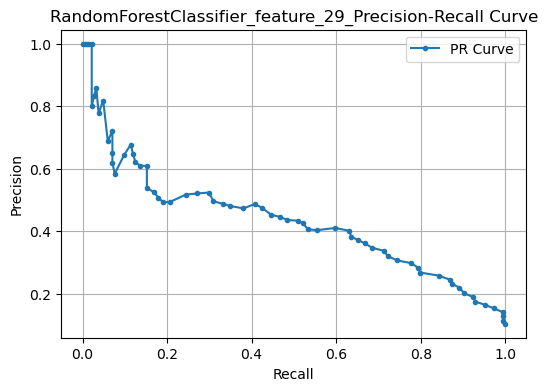

F1 Score: 0.866
PR-AUC Score: 0.429
Accuracy: 0.901
Precision: 0.643
Recall: 0.098
--------------------------------
Confusion Matrix:
 [[1576   10]
 [ 166   18]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.905   0.994     0.947  1586.000
1                 0.643   0.098     0.170   184.000
accuracy          0.901   0.901     0.901     0.901
macro avg         0.774   0.546     0.558  1770.000
weighted avg      0.877   0.901     0.866  1770.000


In [171]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

# Evaluate Model
evaluate_model(rf_clf, X_test, y_test, 0.8)

basic model with 5 selected features

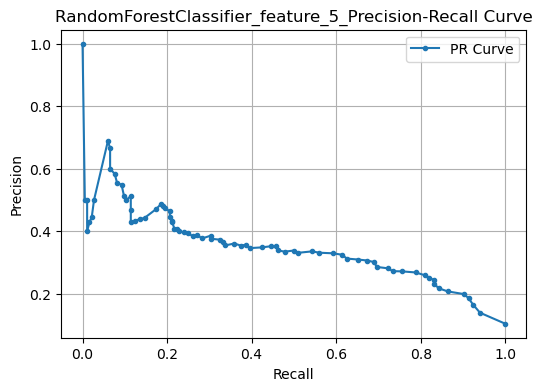

F1 Score: 0.874
PR-AUC Score: 0.341
Accuracy: 0.893
Precision: 0.463
Recall: 0.207
--------------------------------
Confusion Matrix:
 [[1542   44]
 [ 146   38]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.914   0.972     0.942  1586.000
1                 0.463   0.207     0.286   184.000
accuracy          0.893   0.893     0.893     0.893
macro avg         0.688   0.589     0.614  1770.000
weighted avg      0.867   0.893     0.874  1770.000


In [172]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train[final_selected_cols_5], y_train)

# Evaluate Model
evaluate_model(rf_clf, X_test[final_selected_cols_5], y_test, 0.8)

basic model with 13 selected features

Threshold: 0.71, Precision: 0.86, Recall: 0.03
Adjusted Precision: 0.86, Adjusted Recall: 0.03


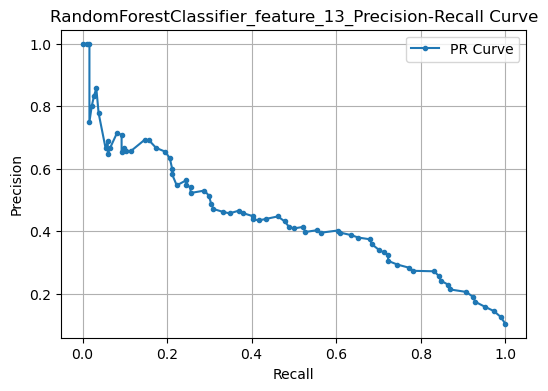

F1 Score: 0.882
PR-AUC Score: 0.435
Accuracy: 0.903
Precision: 0.6
Recall: 0.212
--------------------------------
Confusion Matrix:
 [[1560   26]
 [ 145   39]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.915   0.984     0.948  1586.000
1                 0.600   0.212     0.313   184.000
accuracy          0.903   0.903     0.903     0.903
macro avg         0.757   0.598     0.631  1770.000
weighted avg      0.882   0.903     0.882  1770.000


In [210]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train[final_selected_cols_13], y_train)

# Evaluate Model
evaluate_model(rf_clf, X_test[final_selected_cols_13], y_test, 0.8)

hyperparam tuned model with 13 features selected

In [256]:
rf_clf = RandomForestClassifier(random_state=0)
param_distributions = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

rf_clf_cv = RandomizedSearchCV(rf_clf, param_distributions, n_iter=100, scoring='average_precision', cv=5, random_state=42, n_jobs=-1)
rf_clf_cv.fit(X_train[final_selected_cols_13], y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x191ce4a00>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x191cc6f40>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x191c75640>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x18f35c160>},
                   random_state=42, scoring='average_precision')

Threshold: 0.52, Precision: 0.83, Recall: 0.05
Adjusted Precision: 0.83, Adjusted Recall: 0.05


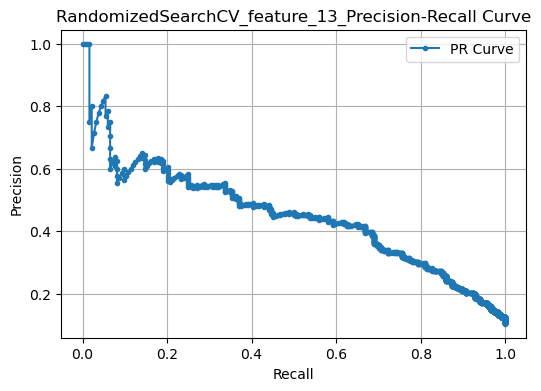

F1 Score: 0.861
PR-AUC Score: 0.453
Accuracy: 0.9
Precision: 0.706
Recall: 0.065
--------------------------------
Confusion Matrix:
 [[1581    5]
 [ 172   12]]
--------------------------------
Classification Report:
               precision  recall  f1-score  support
0                 0.902   0.997     0.947   1586.0
1                 0.706   0.065     0.119    184.0
accuracy          0.900   0.900     0.900      0.9
macro avg         0.804   0.531     0.533   1770.0
weighted avg      0.882   0.900     0.861   1770.0


In [257]:
# Evaluate Model
evaluate_model(rf_clf_cv, X_test[final_selected_cols_13], y_test, 0.8)

### GBM

Threshold: 0.60, Precision: 0.80, Recall: 0.11
Adjusted Precision: 0.80, Adjusted Recall: 0.11


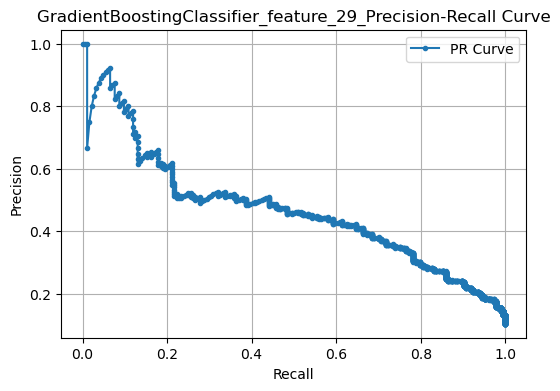

F1 Score: 0.879
PR-AUC Score: 0.472
Accuracy: 0.903
Precision: 0.607
Recall: 0.185
--------------------------------
Confusion Matrix:
 [[1564   22]
 [ 150   34]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.912   0.986     0.948  1586.000
1                 0.607   0.185     0.283   184.000
accuracy          0.903   0.903     0.903     0.903
macro avg         0.760   0.585     0.616  1770.000
weighted avg      0.881   0.903     0.879  1770.000


In [214]:
gbm_clf = GradientBoostingClassifier()

gbm_clf.fit(X_train, y_train)

# Evaluate Model
evaluate_model(gbm_clf, X_test, y_test, 0.8)

Threshold: 0.64, Precision: 0.80, Recall: 0.02
Adjusted Precision: 0.80, Adjusted Recall: 0.02


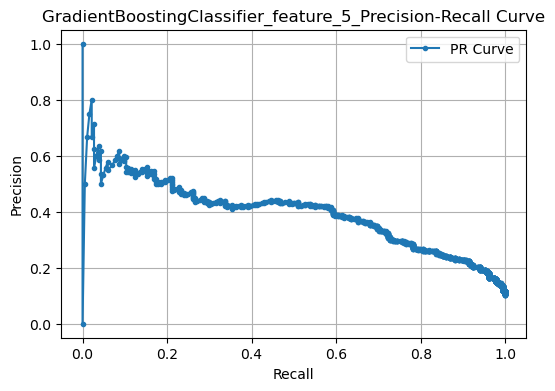

F1 Score: 0.866
PR-AUC Score: 0.4
Accuracy: 0.898
Precision: 0.559
Recall: 0.103
--------------------------------
Confusion Matrix:
 [[1571   15]
 [ 165   19]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.905   0.991     0.946  1586.000
1                 0.559   0.103     0.174   184.000
accuracy          0.898   0.898     0.898     0.898
macro avg         0.732   0.547     0.560  1770.000
weighted avg      0.869   0.898     0.866  1770.000


In [215]:
gbm_clf = GradientBoostingClassifier()

gbm_clf.fit(X_train[final_selected_cols_5], y_train)

# Evaluate Model
evaluate_model(gbm_clf, X_test[final_selected_cols_5], y_test, 0.8)

Threshold: 0.62, Precision: 0.81, Recall: 0.07
Adjusted Precision: 0.81, Adjusted Recall: 0.07


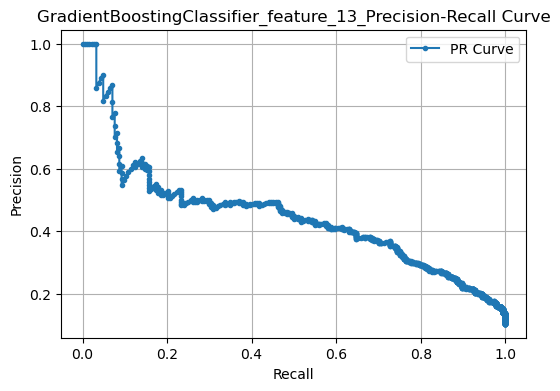

F1 Score: 0.874
PR-AUC Score: 0.451
Accuracy: 0.902
Precision: 0.609
Recall: 0.152
--------------------------------
Confusion Matrix:
 [[1568   18]
 [ 156   28]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.910   0.989     0.947  1586.000
1                 0.609   0.152     0.243   184.000
accuracy          0.902   0.902     0.902     0.902
macro avg         0.759   0.570     0.595  1770.000
weighted avg      0.878   0.902     0.874  1770.000


In [216]:
gbm_clf = GradientBoostingClassifier()

gbm_clf.fit(X_train[final_selected_cols_13], y_train)

# Evaluate Model
evaluate_model(gbm_clf, X_test[final_selected_cols_13], y_test, 0.8)

In [217]:
gbm_clf = GradientBoostingClassifier()
param_distributions = {
    'learning_rate': uniform(0.01, 0.29),
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10)
}

gbm_clf_cv = RandomizedSearchCV(gbm_clf, param_distributions, n_iter = 100, scoring = 'average_precision', cv = 5, random_state = 42, n_jobs = -1)
gbm_clf_cv.fit(X_train[final_selected_cols_13], y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x191c48910>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x191007cd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x19194e250>},
                   random_state=42, scoring='average_precision')

Threshold: 0.64, Precision: 0.72, Recall: 0.07
Adjusted Precision: 0.72, Adjusted Recall: 0.07


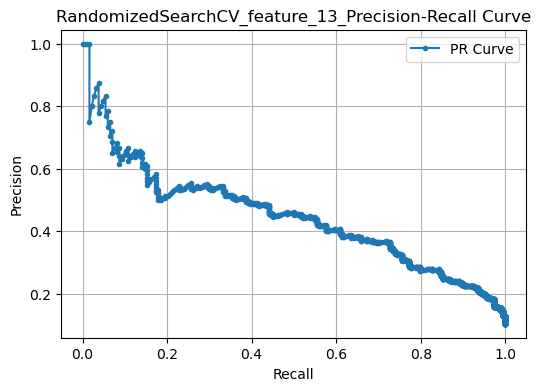

F1 Score: 0.875
PR-AUC Score: 0.45
Accuracy: 0.898
Precision: 0.532
Recall: 0.179
--------------------------------
Confusion Matrix:
 [[1557   29]
 [ 151   33]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.912   0.982     0.945  1586.000
1                 0.532   0.179     0.268   184.000
accuracy          0.898   0.898     0.898     0.898
macro avg         0.722   0.581     0.607  1770.000
weighted avg      0.872   0.898     0.875  1770.000


In [218]:
# Evaluate Model
evaluate_model(gbm_clf_cv, X_test[final_selected_cols_13], y_test, 0.7)

### XGBoost

Threshold: 0.73, Precision: 0.80, Recall: 0.13
Adjusted Precision: 0.80, Adjusted Recall: 0.13


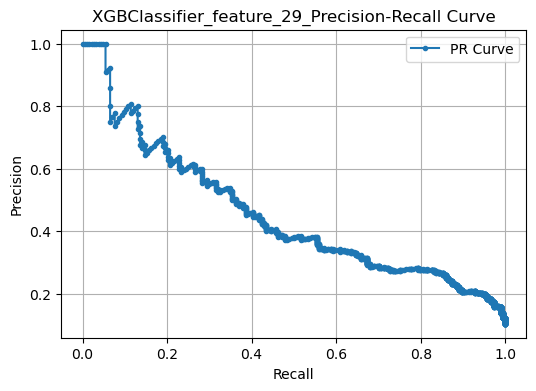

F1 Score: 0.89
PR-AUC Score: 0.455
Accuracy: 0.902
Precision: 0.553
Recall: 0.31
--------------------------------
Confusion Matrix:
 [[1540   46]
 [ 127   57]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.924   0.971     0.947  1586.000
1                 0.553   0.310     0.397   184.000
accuracy          0.902   0.902     0.902     0.902
macro avg         0.739   0.640     0.672  1770.000
weighted avg      0.885   0.902     0.890  1770.000


In [237]:
xgb_clf = XGBClassifier(random_state = 42, max_depth = 5, n_estimators = 100)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
xgb_clf.fit(X_train, y_train)

# Evaluate Model
evaluate_model(xgb_clf, X_test, y_test, 0.8)

Threshold: 0.88, Precision: 1.00, Recall: 0.01
Adjusted Precision: 1.00, Adjusted Recall: 0.01


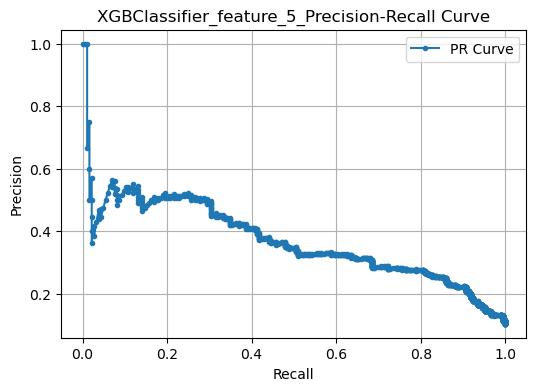

F1 Score: 0.879
PR-AUC Score: 0.374
Accuracy: 0.897
Precision: 0.512
Recall: 0.223
--------------------------------
Confusion Matrix:
 [[1547   39]
 [ 143   41]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.915   0.975     0.944  1586.000
1                 0.512   0.223     0.311   184.000
accuracy          0.897   0.897     0.897     0.897
macro avg         0.714   0.599     0.628  1770.000
weighted avg      0.874   0.897     0.879  1770.000


In [238]:
xgb_clf = XGBClassifier(random_state = 42, max_depth = 5, n_estimators = 100)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
xgb_clf.fit(X_train[final_selected_cols_5], y_train)

# Evaluate Model
evaluate_model(xgb_clf, X_test[final_selected_cols_5], y_test, 0.8)

Threshold: 0.71, Precision: 0.82, Recall: 0.10
Adjusted Precision: 0.82, Adjusted Recall: 0.10


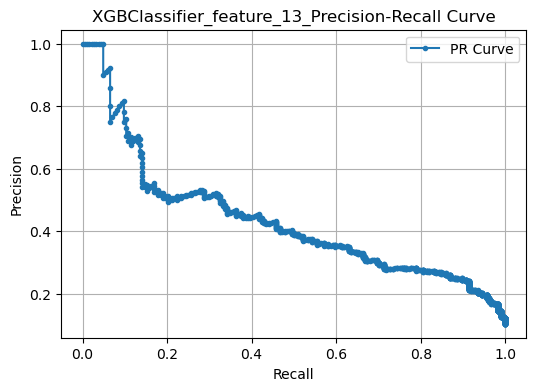

F1 Score: 0.879
PR-AUC Score: 0.436
Accuracy: 0.897
Precision: 0.512
Recall: 0.223
--------------------------------
Confusion Matrix:
 [[1547   39]
 [ 143   41]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.915   0.975     0.944  1586.000
1                 0.512   0.223     0.311   184.000
accuracy          0.897   0.897     0.897     0.897
macro avg         0.714   0.599     0.628  1770.000
weighted avg      0.874   0.897     0.879  1770.000


In [239]:
xgb_clf = XGBClassifier(random_state = 42, max_depth = 5, n_estimators = 100)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
xgb_clf.fit(X_train[final_selected_cols_13], y_train)

# Evaluate Model
evaluate_model(xgb_clf, X_test[final_selected_cols_13], y_test, 0.8)

In [229]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.3, 0.7),
    # 'scale_pos_weight': [scale_pos_weight]
}

# Initialize the XGBClassifier
# xgb_clf = XGBClassifier()

# Set up RandomizedSearchCV with PR-AUC as the scoring metric
xgb_clf_cv = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=param_distributions,
    n_iter=100,
    scoring='average_precision',  # Use PR-AUC (average precision) as the scoring metric
    cv=5,
    random_state=42,
    n_jobs=-1
)

xgb_clf_cv.fit(X_train[final_selected_cols_13], y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x18fb4daf0>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x19188b490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x18f42f850>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x190db6b20>},
                   random_state=42, scoring='average_precision')

Threshold: 0.58, Precision: 0.80, Recall: 0.07
Adjusted Precision: 0.80, Adjusted Recall: 0.07


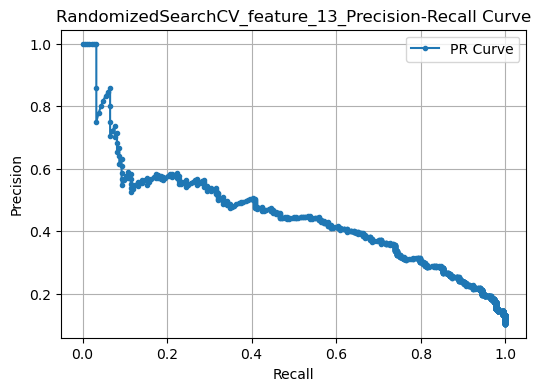

F1 Score: 0.867
PR-AUC Score: 0.455
Accuracy: 0.899
Precision: 0.571
Recall: 0.109
--------------------------------
Confusion Matrix:
 [[1571   15]
 [ 164   20]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.905   0.991     0.946  1586.000
1                 0.571   0.109     0.183   184.000
accuracy          0.899   0.899     0.899     0.899
macro avg         0.738   0.550     0.564  1770.000
weighted avg      0.871   0.899     0.867  1770.000


In [230]:
# Evaluate Model
evaluate_model(xgb_clf_cv, X_test[final_selected_cols_13], y_test, desired_precision= 0.8)

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_col_wise=true` to remove the overhead.
Threshold: 0.68, Precision: 0.81, Recall: 0.11
Adjusted Precision: 0.81, Adjusted Recall: 0.11


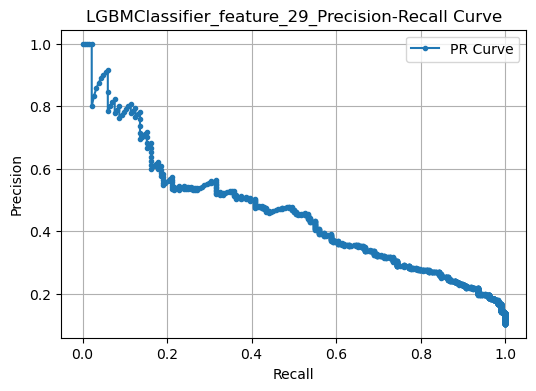

F1 Score: 0.884
PR-AUC Score: 0.463
Accuracy: 0.9
Precision: 0.54
Recall: 0.255
--------------------------------
Confusion Matrix:
 [[1546   40]
 [ 137   47]]
--------------------------------
Classification Report:
               precision  recall  f1-score  support
0                 0.919   0.975     0.946   1586.0
1                 0.540   0.255     0.347    184.0
accuracy          0.900   0.900     0.900      0.9
macro avg         0.729   0.615     0.646   1770.0
weighted avg      0.879   0.900     0.884   1770.0


In [240]:
lgbm_clf = LGBMClassifier(random_state=42, verbose = 0)
lgbm_clf.fit(X_train, y_train)

evaluate_model(lgbm_clf, X_test, y_test, 0.8)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
Threshold: 0.72, Precision: 0.83, Recall: 0.03
Adjusted Precision: 0.83, Adjusted Recall: 0.03


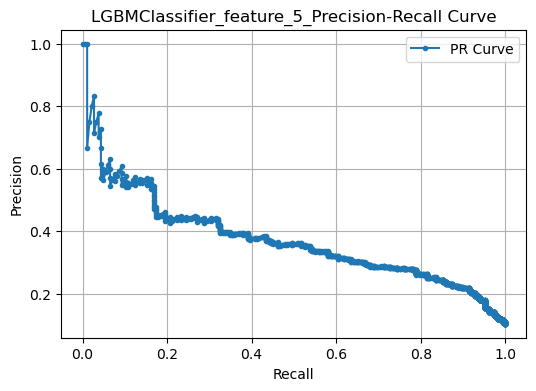

F1 Score: 0.871
PR-AUC Score: 0.377
Accuracy: 0.893
Precision: 0.464
Recall: 0.174
--------------------------------
Confusion Matrix:
 [[1549   37]
 [ 152   32]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.911   0.977     0.943  1586.000
1                 0.464   0.174     0.253   184.000
accuracy          0.893   0.893     0.893     0.893
macro avg         0.687   0.575     0.598  1770.000
weighted avg      0.864   0.893     0.871  1770.000


In [248]:
lgbm_clf = LGBMClassifier(random_state=42, verbose = 0,)
lgbm_clf.fit(X_train_scaled[final_selected_cols_5], y_train,)

evaluate_model(lgbm_clf, X_test_scaled[final_selected_cols_5], y_test, 0.8)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Threshold: 0.78, Precision: 0.80, Recall: 0.04
Adjusted Precision: 0.80, Adjusted Recall: 0.04


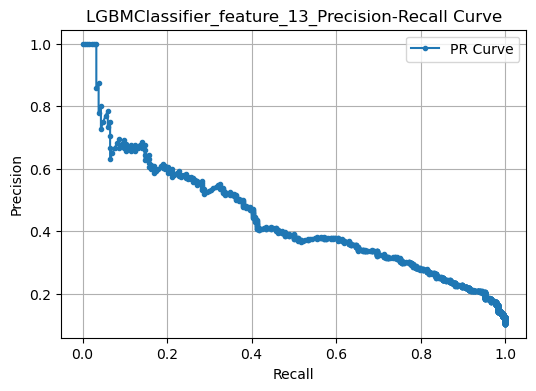

F1 Score: 0.885
PR-AUC Score: 0.443
Accuracy: 0.903
Precision: 0.575
Recall: 0.25
--------------------------------
Confusion Matrix:
 [[1552   34]
 [ 138   46]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.918   0.979     0.947  1586.000
1                 0.575   0.250     0.348   184.000
accuracy          0.903   0.903     0.903     0.903
macro avg         0.747   0.614     0.648  1770.000
weighted avg      0.883   0.903     0.885  1770.000


In [242]:
lgbm_clf = LGBMClassifier(random_state=42, verbose = 0)
lgbm_clf.fit(X_train_scaled[final_selected_cols_13], y_train)

evaluate_model(lgbm_clf, X_test_scaled[final_selected_cols_13], y_test, 0.8)

In [231]:
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_split_gain': [0.0, 0.1, 0.2],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# lgbm_clf_cv = LGBMClassifier(random_state=42, verbose=0)
lgbm_clf_cv = RandomizedSearchCV(
    estimator=lgbm_clf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring= 'average_precision',
    cv=5,
    random_state=42,
    n_jobs=-1
)

lgbm_clf_cv.fit(X_train_scaled[final_selected_cols_13], y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 10, -1],
                                        'min_child_samples': [10, 20, 30],
                                        'min_split_gain': [0.0, 0.1, 0.2],
                                        'n_estimators': [50, 100, 200, 300],
                                        'num_leaves': [20, 31, 40, 50],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='average_precision')

Threshold: 0.66, Precision: 0.82, Recall: 0.08
Adjusted Precision: 0.82, Adjusted Recall: 0.08


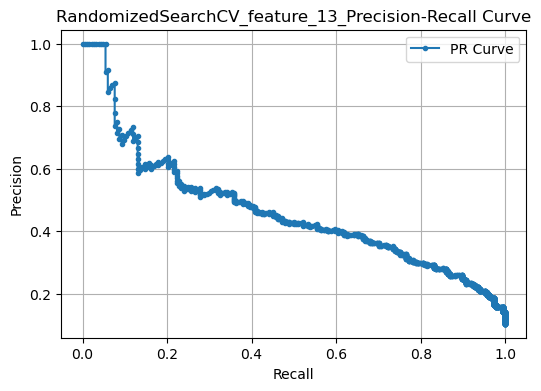

F1 Score: 0.883
PR-AUC Score: 0.467
Accuracy: 0.903
Precision: 0.597
Recall: 0.217
--------------------------------
Confusion Matrix:
 [[1559   27]
 [ 144   40]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.915   0.983     0.948  1586.000
1                 0.597   0.217     0.319   184.000
accuracy          0.903   0.903     0.903     0.903
macro avg         0.756   0.600     0.633  1770.000
weighted avg      0.882   0.903     0.883  1770.000


In [232]:
# Evaluate Model
evaluate_model(lgbm_clf_cv, X_test_scaled[final_selected_cols_13], y_test, desired_precision= 0.8)

### CatBoost

In [249]:
cb_clf = CatBoostClassifier(verbose = 0, random_state = 42)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
cb_clf.fit(X_train, y_train)

Threshold: 0.66, Precision: 0.81, Recall: 0.11
Adjusted Precision: 0.81, Adjusted Recall: 0.11


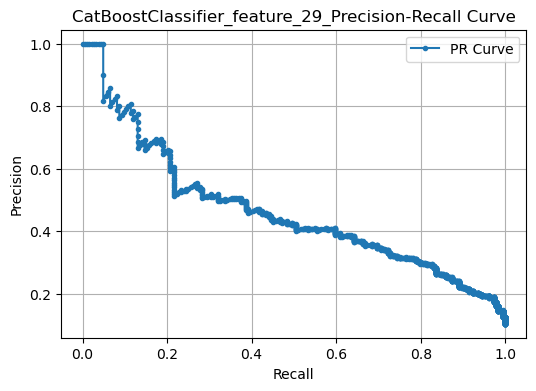

F1 Score: 0.88
PR-AUC Score: 0.467
Accuracy: 0.9
Precision: 0.548
Recall: 0.217
--------------------------------
Confusion Matrix:
 [[1553   33]
 [ 144   40]]
--------------------------------
Classification Report:
               precision  recall  f1-score  support
0                 0.915   0.979     0.946   1586.0
1                 0.548   0.217     0.311    184.0
accuracy          0.900   0.900     0.900      0.9
macro avg         0.732   0.598     0.629   1770.0
weighted avg      0.877   0.900     0.880   1770.0


In [250]:
#  Evaluate Model
evaluate_model(cb_clf, X_test, y_test, 0.8)

Threshold: 0.66, Precision: 0.81, Recall: 0.07
Adjusted Precision: 0.81, Adjusted Recall: 0.07


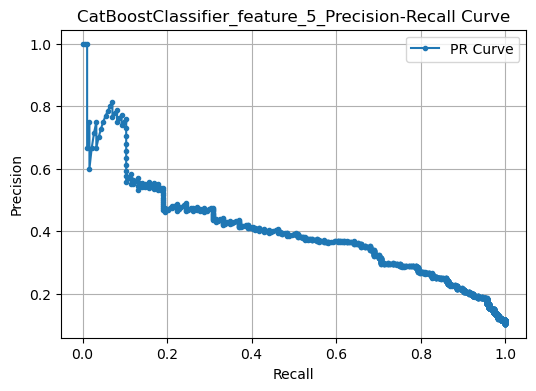

F1 Score: 0.875
PR-AUC Score: 0.408
Accuracy: 0.899
Precision: 0.542
Recall: 0.174
--------------------------------
Confusion Matrix:
 [[1559   27]
 [ 152   32]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.911   0.983     0.946  1586.000
1                 0.542   0.174     0.263   184.000
accuracy          0.899   0.899     0.899     0.899
macro avg         0.727   0.578     0.605  1770.000
weighted avg      0.873   0.899     0.875  1770.000


In [251]:
cb_clf = CatBoostClassifier(verbose = 0, random_state = 42)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
cb_clf.fit(X_train[final_selected_cols_5], y_train)
#  Evaluate Model
evaluate_model(cb_clf, X_test[final_selected_cols_5], y_test, 0.8)

Threshold: 0.75, Precision: 0.80, Recall: 0.07
Adjusted Precision: 0.80, Adjusted Recall: 0.07


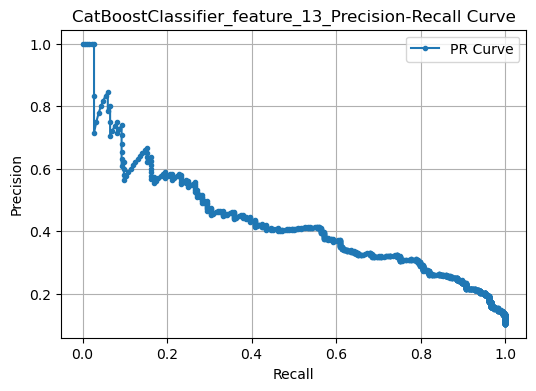

F1 Score: 0.884
PR-AUC Score: 0.434
Accuracy: 0.903
Precision: 0.581
Recall: 0.234
--------------------------------
Confusion Matrix:
 [[1555   31]
 [ 141   43]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.917   0.980     0.948  1586.000
1                 0.581   0.234     0.333   184.000
accuracy          0.903   0.903     0.903     0.903
macro avg         0.749   0.607     0.640  1770.000
weighted avg      0.882   0.903     0.884  1770.000


In [253]:
cb_clf = CatBoostClassifier(verbose = 0, random_state = 42)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
cb_clf.fit(X_train[final_selected_cols_13], y_train)
#  Evaluate Model
evaluate_model(cb_clf, X_test[final_selected_cols_13], y_test, 0.8)

In [254]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the parameter distributions for RandomizedSearchCV for CatBoost
param_distributions = {
    'iterations': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'depth': randint(3, 10),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
    'random_strength': uniform(0, 1),
    'border_count': randint(32, 255),
    'scale_pos_weight': [scale_pos_weight]
}

# Set up RandomizedSearchCV with PR-AUC as the scoring metric
cb_clf_cv = RandomizedSearchCV(
    estimator=cb_clf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='average_precision',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
cb_clf_cv.fit(X_train[final_selected_cols_13], y_train)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Avoid using `tokenizers` before the fork if p

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x18f2fe8b0>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bagging_temperature': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x18f294d60>,
                                        'border_count': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x18f326be0>,
                                        'depth': <scipy.stats._distn_infras...
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x18f2ad850>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x18f2fe220>,
                                        'random_strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x18f324cd0>,
                                        'scale_pos_weight': [8.589430894308943]},
                   random_state=42, scoring='average_precision')

Threshold: 0.90, Precision: 0.80, Recall: 0.07
Adjusted Precision: 0.80, Adjusted Recall: 0.07


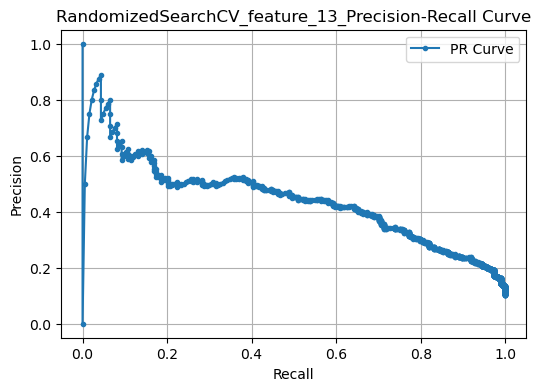

F1 Score: 0.816
PR-AUC Score: 0.445
Accuracy: 0.776
Precision: 0.292
Recall: 0.81
--------------------------------
Confusion Matrix:
 [[1224  362]
 [  35  149]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.972   0.772     0.860  1586.000
1                 0.292   0.810     0.429   184.000
accuracy          0.776   0.776     0.776     0.776
macro avg         0.632   0.791     0.645  1770.000
weighted avg      0.901   0.776     0.816  1770.000


In [255]:
# Evaluate the parameter optimized, final_selected_columns model
evaluate_model(cb_clf_cv, X_test[final_selected_cols_13], y_test, 0.8)

# Final Summary
| Model       | Metric    | Base (29) | 5     | 13    | Param Tuned |
|-------------|-----------|-----------|-------|-------|-------------|
| **RF**      | F1 Score  | 0.866     | 0.874 | 0.882 | 0.861   |
|             | PR-AUC    | 0.429     | 0.341 | 0.425 | 0.453       |
| **GBM**     | F1 Score  | 0.879     | 0.866 | 0.874 | 0.875   |
|             | PR-AUC    | 0.472     | 0.400 | 0.451 | 0.450       |
| **XGB**     | F1 Score  | 0.887     | 0.879 | 0.879 | 0.867       |
|             | PR-AUC    | 0.455     | 0.374 | 0.436 | 0.455       |
| **LGBM**    | F1 Score  | 0.884     | 0.871 | 0.885 | 0.883  |
|             | PR-AUC    | 0.463     | 0.377 | 0.443 | 0.467       |
| **CatBoost**| F1 Score  | 0.880     | 0.875 | 0.884 | 0.816       |
|             | PR-AUC    | 0.467     | 0.408 | 0.434 | 0.445       |
| **Mean**    | F1 Score  | 0.879     | 0.873 | 0.881 | 0.860       |
|             | PR-AUC    | 0.457     | 0.380 | 0.438 | 0.454       |


### Average Model Performance by Feature Set

- **All features (29):**
  - F1 Score: 0.879
  - PR-AUC: 0.457

- **Selected features (5):**
  - F1 Score: 0.873
  - PR-AUC: 0.380

- **Selected features (13):**
  - F1 Score: 0.881
  - PR-AUC: 0.438

- **Hyperparameter-tuned model with selected features:**
  - F1 Score: 0.860
  - PR-AUC: 0.454

### Key Takeaway
The results demonstrate that even after reducing the feature set from 29 to as few as 5 features, the models still achieved nearly the same performance as the baseline. This is significant, as it suggests we successfully reduced model complexity while retaining predictive power. This highlights that the features selected have a substantial impact on the model’s predictions.

---

### Considerations

#### Threshold Selection
In this lending scenario, choosing the right threshold is critical. This process is not just about selecting the highest-scoring model but involves balancing **precision** and **recall** using the PR-AUC curve. This balance depends on the intended use:

- **Prioritizing Precision**: If minimizing the risk of issuing bad loans is the primary concern, setting a threshold that ensures higher precision would be preferred.
- **Prioritizing Recall**: If the goal is to maximize the number of accepted applicants, higher recall may be prioritized, allowing for a more inclusive model.

Based on these objectives, I would adjust thresholds and hyperparameters to achieve the desired trade-off between precision and recall.

* My idea  

In lending scenarios, precision is crucial to minimize the risk of issuing bad loans.  
Therefore, if we prioritize precision and aim for a minimum precision of 0.8, the precision, recall, and thresholds are shown in the table below.  
XGBoost performs the best, achieving the highest recall while maintaining comparable precision.  
At this optimal point, the threshold is 0.73, making 0.73 a suitable threshold to use.

| Model         | Precision | Recall | Threshold |
|---------------|-----------|--------|-----------|
| RandomForest  | 0.81      | 0.05   | 0.58      |
| GBM           | 0.80      | 0.11   | 0.60      |
| **XGBoost**   | **0.80**  | **0.13** | **0.73**  |
| LGBM          | 0.82      | 0.08   | 0.66      |
| CatBoost      | 0.81      | 0.11   | 0.66      |​⬤

